In [1]:
from google.colab import files
uploaded = files.upload()

Saving train_FD003.txt to train_FD003.txt


In [2]:
from google.colab import files
uploaded = files.upload()

Saving RUL_FD003.txt to RUL_FD003.txt


In [3]:
from google.colab import files
uploaded = files.upload()

Saving test_FD003.txt to test_FD003.txt


Number of columns in training data: 26
Shape of training data: (24720, 26)

Training data loaded successfully!
   unit_number  cycle   ops_1   ops_2  ops_3    sm_1    sm_2     sm_3  \
0            1      1 -0.0005  0.0004  100.0  518.67  642.36  1583.23   
1            1      2  0.0008 -0.0003  100.0  518.67  642.50  1584.69   
2            1      3 -0.0014 -0.0002  100.0  518.67  642.18  1582.35   
3            1      4 -0.0020  0.0001  100.0  518.67  642.92  1585.61   
4            1      5  0.0016  0.0000  100.0  518.67  641.68  1588.63   

      sm_4   sm_5  ...   sm_12    sm_13    sm_14   sm_15  sm_16  sm_17  sm_18  \
0  1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246   0.03    391   2388   
1  1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403   0.03    392   2388   
2  1405.61  14.62  ...  522.03  2388.00  8150.17  8.3901   0.03    391   2388   
3  1392.27  14.62  ...  522.49  2388.08  8146.56  8.3878   0.03    392   2388   
4  1397.65  14.62  ...  522.58  2388.03  8147

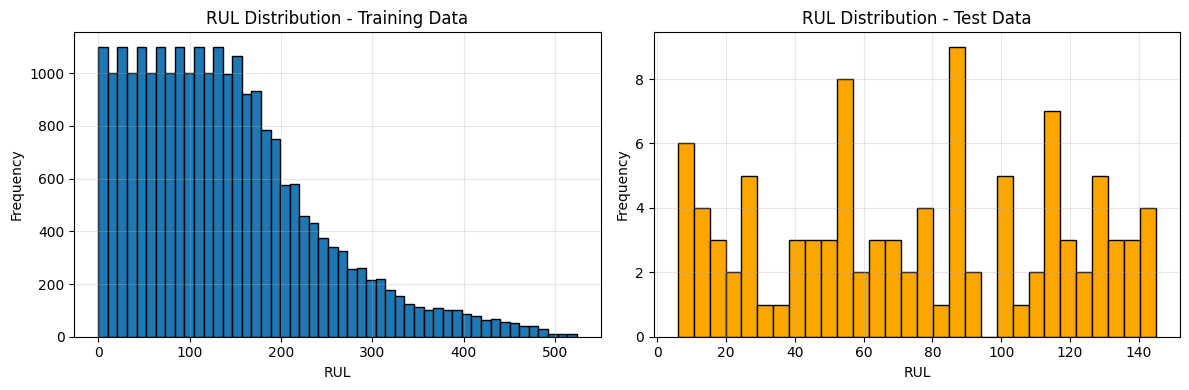

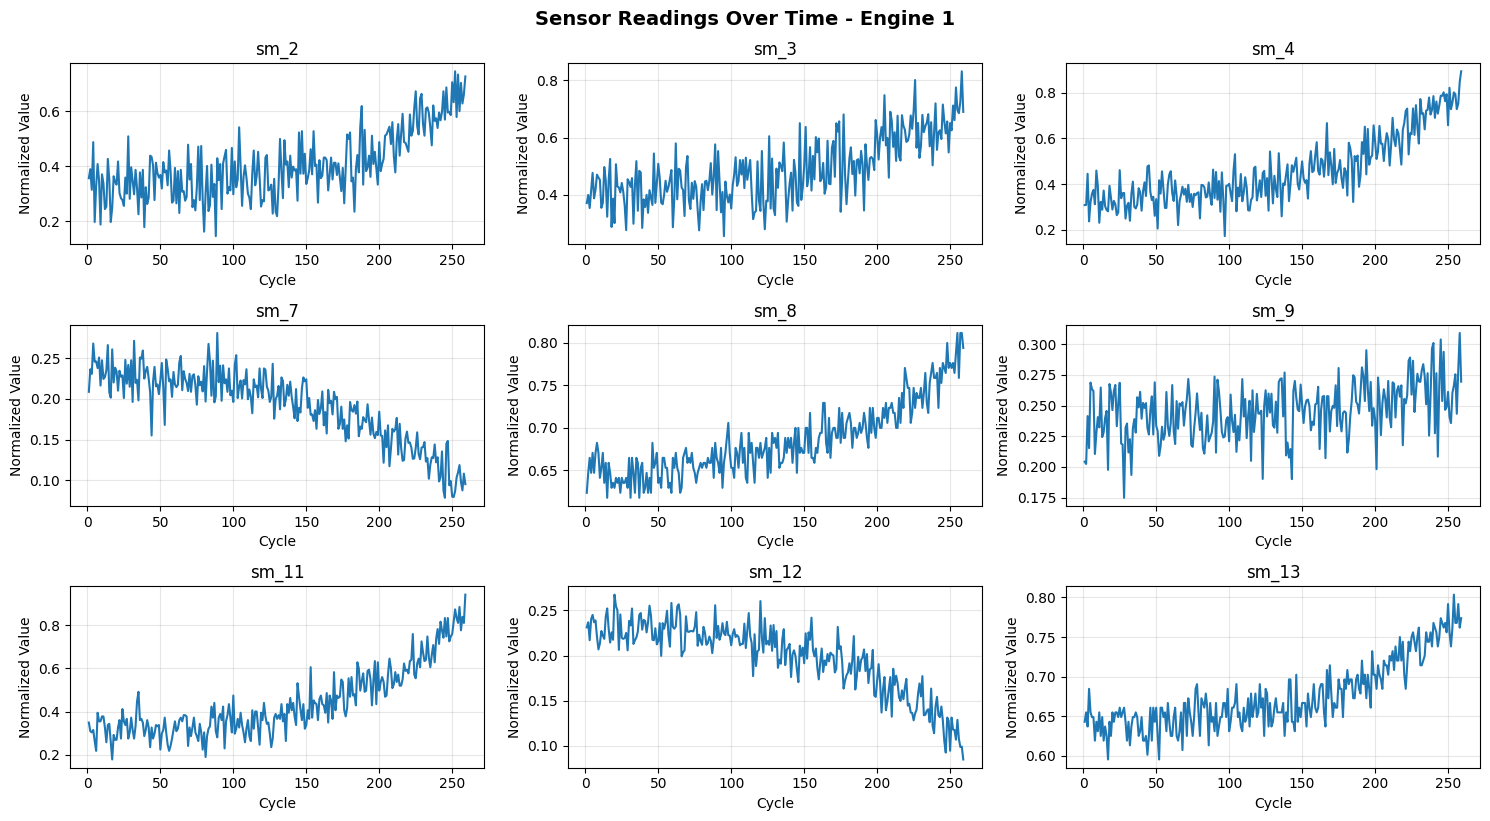


SETUP COMPLETE - Ready for model training!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# ============================================
# 1. LOAD TRAINING DATA
# ============================================
# Use raw string (r) to avoid SyntaxWarning
df_train = pd.read_csv('train_FD003.txt', sep=r'\s+', header=None, engine='python')

# Check the actual number of columns in your data
print(f"Number of columns in training data: {df_train.shape[1]}")
print(f"Shape of training data: {df_train.shape}")

# Assign column names based on 26 columns (standard C-MAPSS structure)
df_train.columns = ['unit_number', 'cycle', 'ops_1', 'ops_2', 'ops_3',
                    'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7',
                    'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14',
                    'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']

print("\nTraining data loaded successfully!")
print(df_train.head())

# ============================================
# 2. LOAD TEST DATA
# ============================================
df_test = pd.read_csv('test_FD003.txt', sep=r'\s+', header=None, engine='python')

# Assign same column names
df_test.columns = ['unit_number', 'cycle', 'ops_1', 'ops_2', 'ops_3',
                   'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7',
                   'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14',
                   'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']

print(f"\nTest data shape: {df_test.shape}")

# ============================================
# 3. LOAD RUL (Remaining Useful Life) VALUES
# ============================================
df_rul = pd.read_csv('RUL_FD003.txt', sep=r'\s+', header=None, engine='python')
df_rul.columns = ['RUL']
df_rul['unit_number'] = df_rul.index + 1

print(f"\nRUL data shape: {df_rul.shape}")
print(df_rul.head())

# ============================================
# 4. CALCULATE RUL FOR TRAINING DATA
# ============================================
# Calculate max cycle for each unit
max_cycle = df_train.groupby('unit_number')['cycle'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

# Merge with training data
df_train = df_train.merge(max_cycle, on='unit_number', how='left')

# Calculate RUL (Remaining Useful Life)
df_train['RUL'] = df_train['max_cycle'] - df_train['cycle']

print("\nRUL calculated for training data!")
print(df_train[['unit_number', 'cycle', 'max_cycle', 'RUL']].head(10))

# ============================================
# 5. DATA EXPLORATION
# ============================================
print("\n" + "="*50)
print("DATA STATISTICS")
print("="*50)
print(f"Number of engines in training: {df_train['unit_number'].nunique()}")
print(f"Number of engines in test: {df_test['unit_number'].nunique()}")
print(f"\nTraining data info:")
print(df_train.describe())

# ============================================
# 6. FEATURE SELECTION (Remove constant features)
# ============================================
# Check for constant operational settings
ops_cols = ['ops_1', 'ops_2', 'ops_3']
sensor_cols = [f'sm_{i}' for i in range(1, 22)]

print("\n" + "="*50)
print("CHECKING FOR CONSTANT FEATURES")
print("="*50)

# Check variance
for col in ops_cols + sensor_cols:
    variance = df_train[col].var()
    if variance < 0.001:
        print(f"{col}: Nearly constant (variance = {variance:.6f})")

# Remove features with very low variance
threshold = 0.001
variance = df_train[sensor_cols].var()
constant_features = variance[variance < threshold].index.tolist()

print(f"\nFeatures to remove (variance < {threshold}): {constant_features}")

# Keep only varying features
varying_features = [col for col in sensor_cols if col not in constant_features]
print(f"Varying sensor features: {varying_features}")

# ============================================
# 7. NORMALIZATION
# ============================================
scaler = MinMaxScaler()

# Features to normalize (operational settings + varying sensors)
features_to_normalize = ops_cols + varying_features

# Fit scaler on training data
df_train[features_to_normalize] = scaler.fit_transform(df_train[features_to_normalize])

# Transform test data
df_test[features_to_normalize] = scaler.transform(df_test[features_to_normalize])

print("\n" + "="*50)
print("DATA NORMALIZED")
print("="*50)
print(df_train[features_to_normalize].head())

# ============================================
# 8. PREPARE DATA FOR MODELING
# ============================================
# Select features for modeling
feature_columns = ops_cols + varying_features

X_train = df_train[feature_columns]
y_train = df_train['RUL']

X_test = df_test[feature_columns]
y_test = df_rul['RUL']

print("\n" + "="*50)
print("DATA READY FOR MODELING")
print("="*50)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# ============================================
# 9. VISUALIZATION
# ============================================
# Plot RUL distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_train['RUL'], bins=50, edgecolor='black')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.title('RUL Distribution - Training Data')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df_rul['RUL'], bins=30, edgecolor='black', color='orange')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.title('RUL Distribution - Test Data')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot sensor degradation for first engine
unit_1 = df_train[df_train['unit_number'] == 1]

plt.figure(figsize=(15, 8))
for i, sensor in enumerate(varying_features[:9], 1):
    plt.subplot(3, 3, i)
    plt.plot(unit_1['cycle'], unit_1[sensor])
    plt.xlabel('Cycle')
    plt.ylabel('Normalized Value')
    plt.title(f'{sensor}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Sensor Readings Over Time - Engine 1', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print("\n" + "="*50)
print("SETUP COMPLETE - Ready for model training!")
print("="*50)

Training samples: 19776
Validation samples: 4944
Test samples: 100

TRAINING MULTIPLE MODELS

[1/6] Training Linear Regression...
✓ RMSE: 57.77, R²: -0.9475

[2/6] Training Ridge Regression...
✓ RMSE: 57.73, R²: -0.9451

[3/6] Training Lasso Regression...
✓ RMSE: 57.26, R²: -0.9136

[4/6] Training Random Forest...
✓ RMSE: 51.88, R²: -0.5705

[5/6] Training Gradient Boosting...
✓ RMSE: 53.41, R²: -0.6647

[6/6] Training Neural Network (MLP)...
✓ RMSE: 54.99, R²: -0.7644

MODEL PERFORMANCE COMPARISON

             Model      RMSE       MAE        R²   NASA_Score
    Random Forest 51.876732 36.865389 -0.570494 1.163027e+07
Gradient Boosting 53.410575 38.755487 -0.664737 1.029669e+08
   Neural Network 54.985791 40.712692 -0.764380 8.888496e+08
 Lasso Regression 57.264157 47.474686 -0.913625 1.965376e+08
 Ridge Regression 57.733011 47.667245 -0.945089 4.171026e+08
Linear Regression 57.768315 47.682667 -0.947469 4.577251e+08

🏆 BEST MODEL: Random Forest
   RMSE: 51.88 cycles
   MAE: 36.87 cy

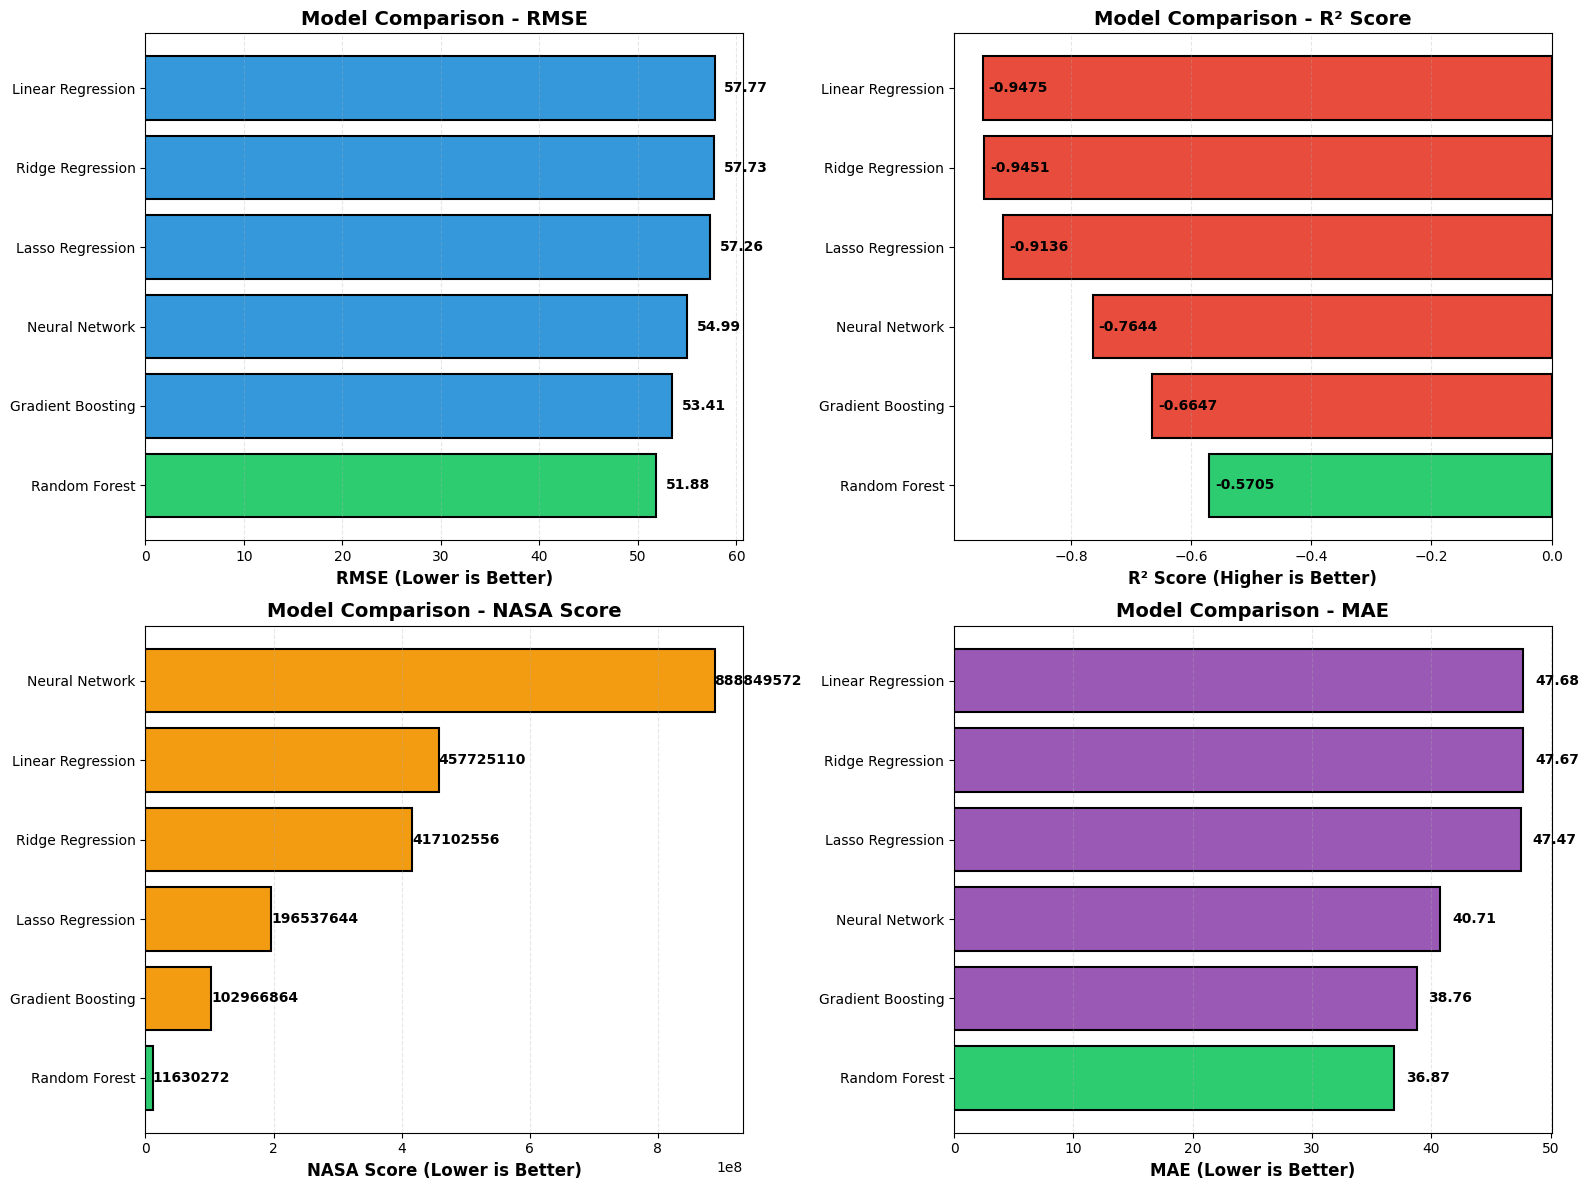

✓ Plot 1: Model Comparison saved


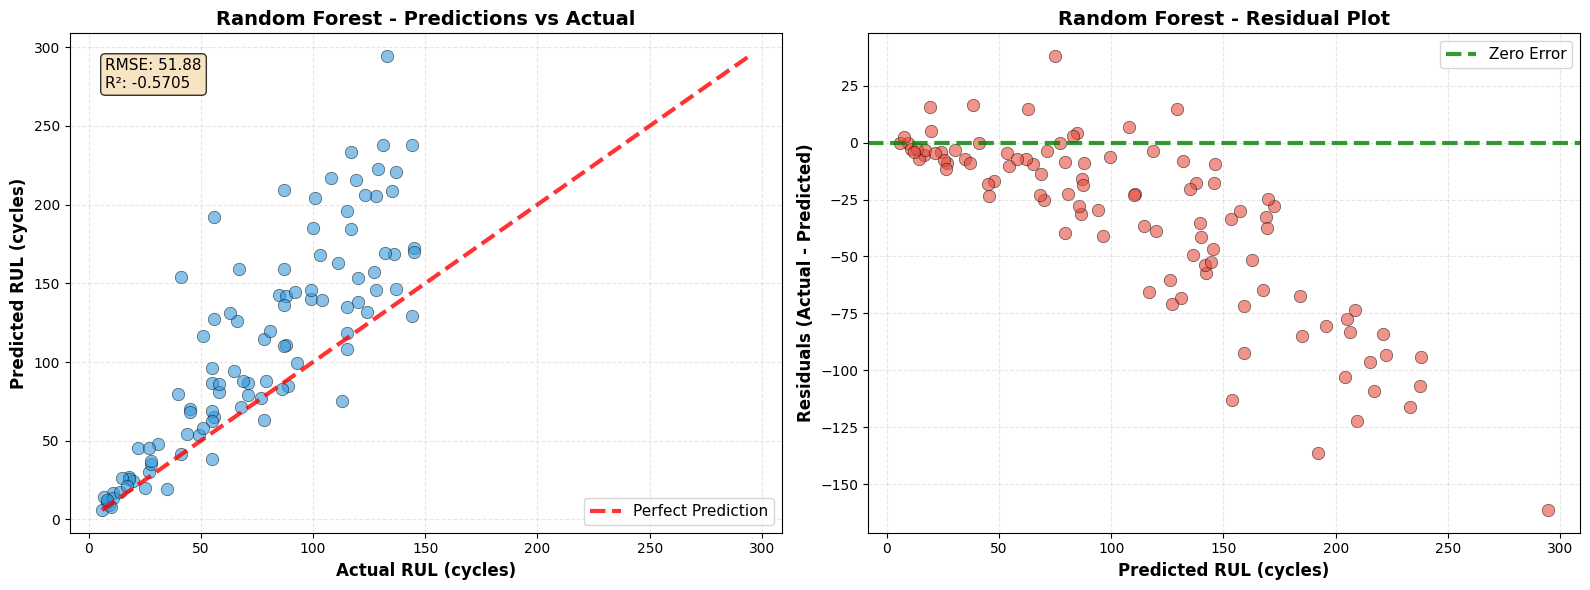

✓ Plot 2: Predictions Analysis saved


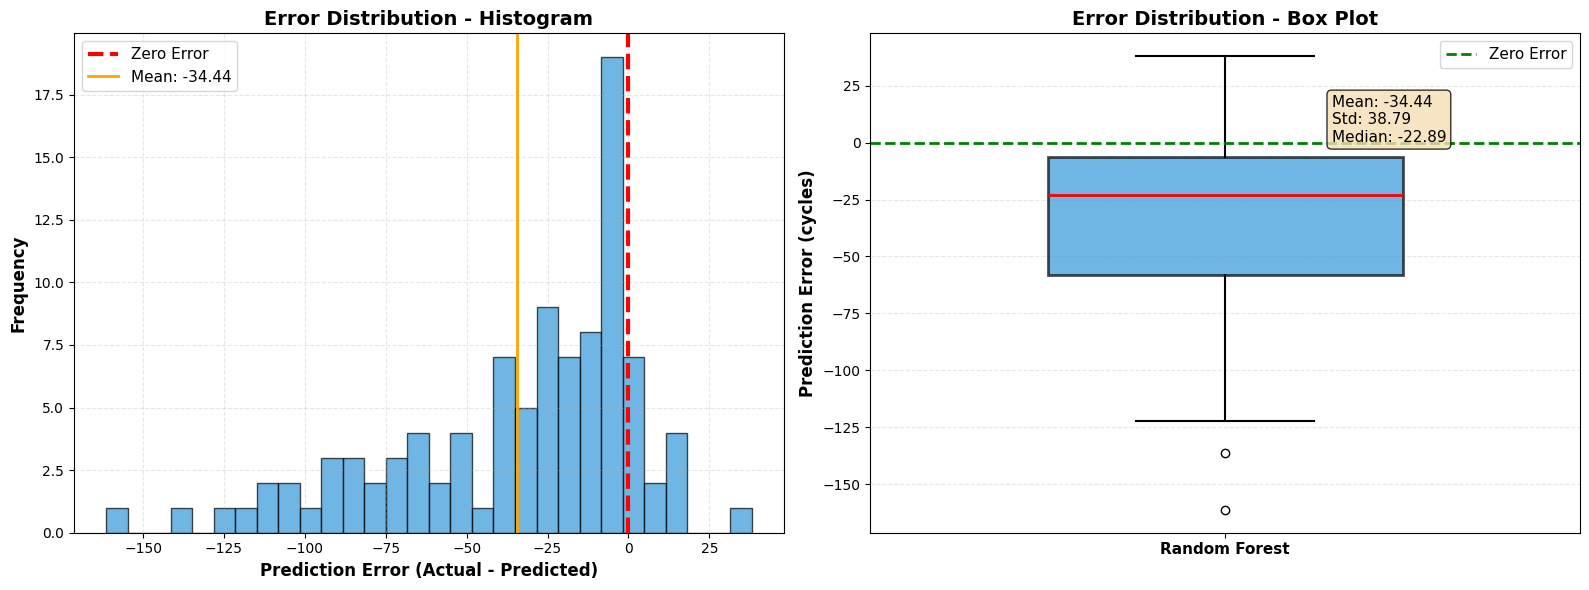

✓ Plot 3: Error Distribution saved


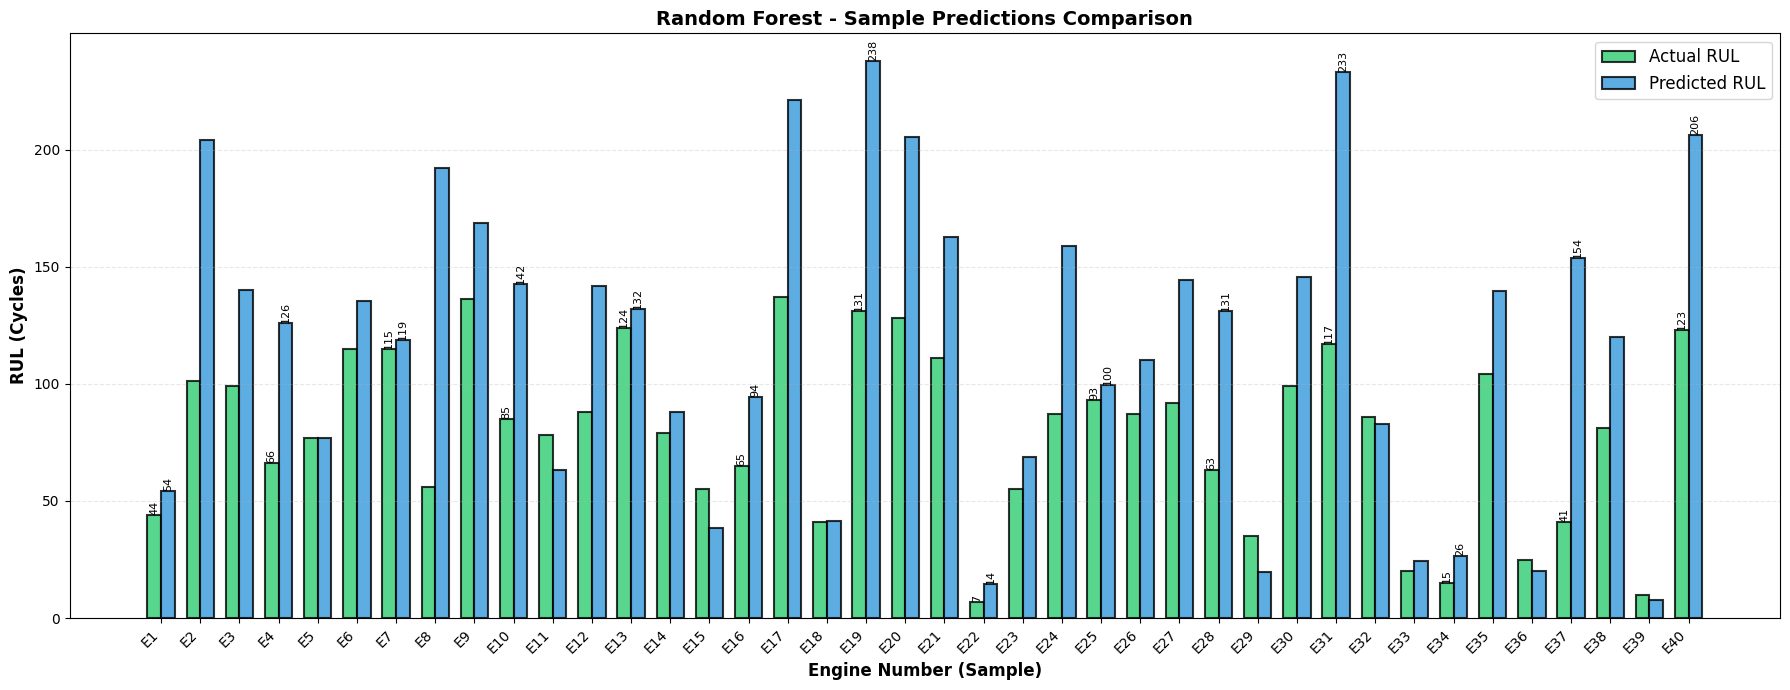

✓ Plot 4: Sample Predictions saved


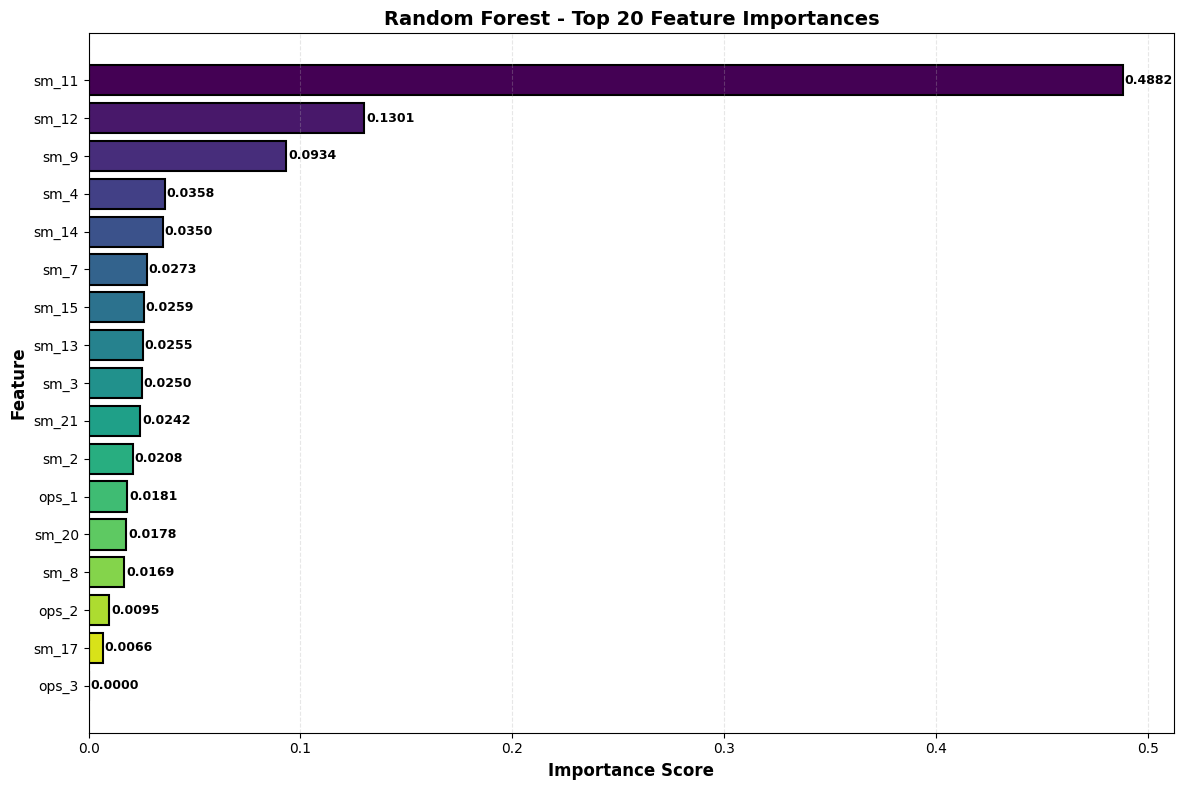

✓ Plot 5: Feature Importance saved


/tmp/ipython-input-2010010474.py:414: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2010010474.py:415: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


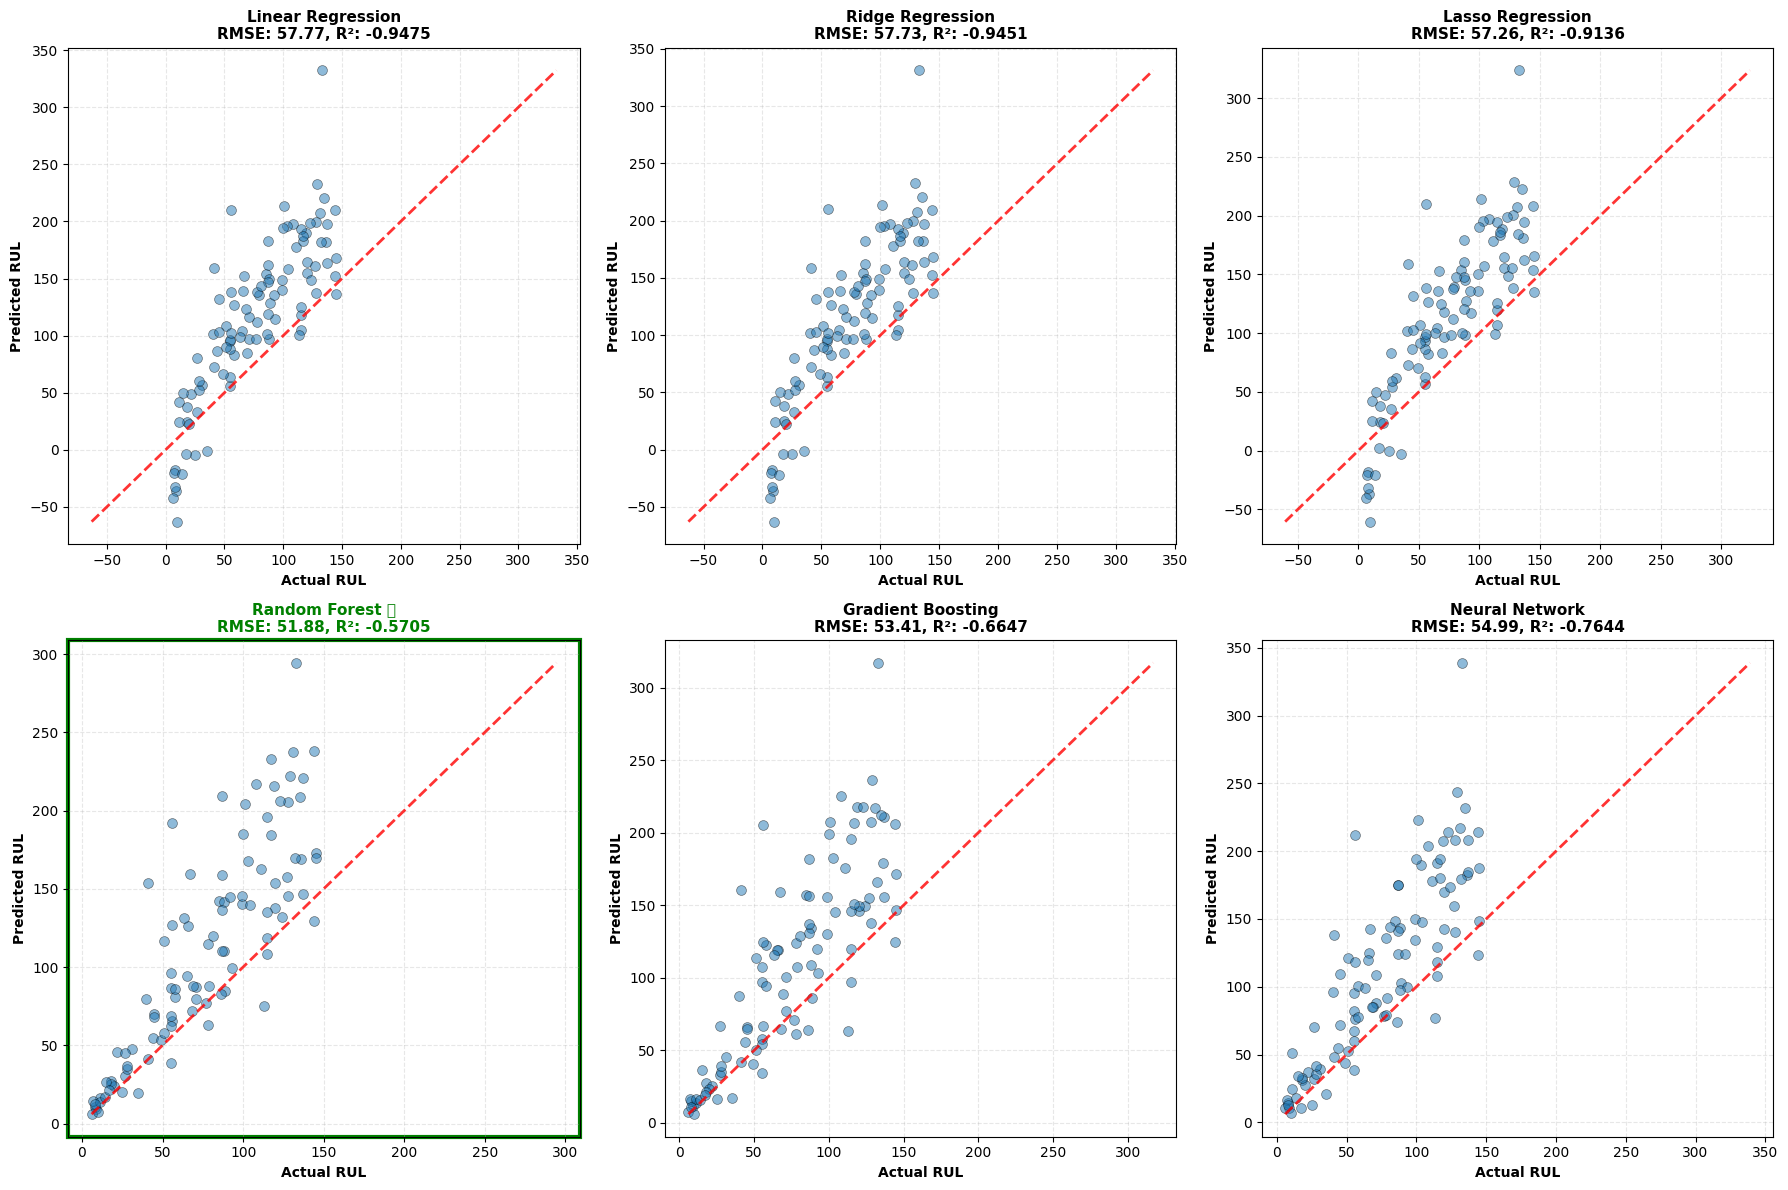

✓ Plot 6: All Models Comparison saved

SAVING RESULTS
✓ Predictions saved to 'rul_predictions.csv'
✓ Model comparison saved to 'model_comparison.csv'
✓ Statistics saved to 'prediction_statistics.csv'

FINAL SUMMARY

📊 Dataset: NASA C-MAPSS FD003
   Training engines: 100
   Test engines: 100
   Features used: 17

🏆 Best Model: Random Forest
   RMSE: 51.88 cycles
   MAE: 36.87 cycles
   R² Score: -0.5705
   NASA Score: 11630271.95

📈 Error Analysis:
   Mean Error: -34.44 cycles
   Std Error: 38.79 cycles
   Median Error: -22.89 cycles
   Within ±10 cycles: 33.0%
   Within ±20 cycles: 46.0%
   Within ±30 cycles: 57.0%


In [ ]:
# Prepare final training and test sets
X_train_full = df_train[feature_columns]
y_train_full = df_train['RUL']

# For test: use only the last cycle of each engine
df_test_last = df_test.groupby('unit_number').last().reset_index()
X_test = df_test_last[feature_columns]
y_test = df_rul['RUL']

# Split training data for validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# ============================================
# MODEL TRAINING
# ============================================
print("\n" + "="*60)
print("TRAINING MULTIPLE MODELS")
print("="*60)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    """Calculate comprehensive metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # NASA scoring function (asymmetric - penalizes late predictions more)
    errors = y_pred - y_true
    score = 0
    for error in errors:
        if error < 0:  # Early prediction (safer)
            score += np.exp(-error/13) - 1
        else:  # Late prediction (dangerous)
            score += np.exp(error/10) - 1

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'NASA_Score': score
    }

results = []
model_predictions = {}

# Model 1: Linear Regression
print("\n[1/6] Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
model_predictions['Linear Regression'] = y_pred_lr
results.append(evaluate_model(y_test, y_pred_lr, 'Linear Regression'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 2: Ridge Regression
print("\n[2/6] Training Ridge Regression...")
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
model_predictions['Ridge Regression'] = y_pred_ridge
results.append(evaluate_model(y_test, y_pred_ridge, 'Ridge Regression'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 3: Lasso Regression
print("\n[3/6] Training Lasso Regression...")
lasso_model = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
model_predictions['Lasso Regression'] = y_pred_lasso
results.append(evaluate_model(y_test, y_pred_lasso, 'Lasso Regression'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 4: Random Forest
print("\n[4/6] Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
model_predictions['Random Forest'] = y_pred_rf
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 5: Gradient Boosting
print("\n[5/6] Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
model_predictions['Gradient Boosting'] = y_pred_gb
results.append(evaluate_model(y_test, y_pred_gb, 'Gradient Boosting'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 6: Neural Network
print("\n[6/6] Training Neural Network (MLP)...")
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=False
)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
model_predictions['Neural Network'] = y_pred_mlp
results.append(evaluate_model(y_test, y_pred_mlp, 'Neural Network'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# ============================================
# RESULTS COMPARISON
# ============================================
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')
print("\n", results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_predictions = model_predictions[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:.2f} cycles")
print(f"   MAE: {results_df.iloc[0]['MAE']:.2f} cycles")
print(f"   R²: {results_df.iloc[0]['R²']:.4f}")
print(f"   NASA Score: {results_df.iloc[0]['NASA_Score']:.2f}")

# ============================================
# VISUALIZATIONS
# ============================================
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# Calculate residuals
residuals = y_test.values - best_predictions

# PLOT 1: Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE Comparison
ax = axes[0, 0]
results_sorted = results_df.sort_values('RMSE', ascending=True)
colors = ['#2ecc71' if x == best_model_name else '#3498db' for x in results_sorted['Model']]
ax.barh(results_sorted['Model'], results_sorted['RMSE'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('RMSE (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(results_sorted['RMSE']):
    ax.text(v + 1, i, f'{v:.2f}', va='center', fontweight='bold')

# R² Comparison
ax = axes[0, 1]
results_sorted = results_df.sort_values('R²', ascending=False)
colors = ['#2ecc71' if x == best_model_name else '#e74c3c' for x in results_sorted['Model']]
ax.barh(results_sorted['Model'], results_sorted['R²'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('R² Score (Higher is Better)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(results_sorted['R²']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# NASA Score Comparison
ax = axes[1, 0]
results_sorted = results_df.sort_values('NASA_Score', ascending=True)
colors = ['#2ecc71' if x == best_model_name else '#f39c12' for x in results_sorted['Model']]
ax.barh(results_sorted['Model'], results_sorted['NASA_Score'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('NASA Score (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - NASA Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(results_sorted['NASA_Score']):
    ax.text(v + 50, i, f'{v:.0f}', va='center', fontweight='bold')

# MAE Comparison
ax = axes[1, 1]
results_sorted = results_df.sort_values('MAE', ascending=True)
colors = ['#2ecc71' if x == best_model_name else '#9b59b6' for x in results_sorted['Model']]
ax.barh(results_sorted['Model'], results_sorted['MAE'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('MAE (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - MAE', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(results_sorted['MAE']):
    ax.text(v + 1, i, f'{v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 1: Model Comparison saved")

# PLOT 2: Prediction vs Actual (Best Model)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax = axes[0]
ax.scatter(y_test, best_predictions, alpha=0.6, s=80, color='#3498db', edgecolor='black', linewidth=0.5)
min_val = min(y_test.min(), best_predictions.min())
max_val = max(y_test.max(), best_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Perfect Prediction', alpha=0.8)
ax.set_xlabel('Actual RUL (cycles)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted RUL (cycles)', fontsize=12, fontweight='bold')
ax.set_title(f'{best_model_name} - Predictions vs Actual', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

# Add RMSE annotation
rmse_text = f'RMSE: {results_df.iloc[0]["RMSE"]:.2f}\nR²: {results_df.iloc[0]["R²"]:.4f}'
ax.text(0.05, 0.95, rmse_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Residual plot
ax = axes[1]
ax.scatter(best_predictions, residuals, alpha=0.6, s=80, color='#e74c3c', edgecolor='black', linewidth=0.5)
ax.axhline(y=0, color='green', linestyle='--', lw=3, label='Zero Error', alpha=0.8)
ax.set_xlabel('Predicted RUL (cycles)', fontsize=12, fontweight='bold')
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
ax.set_title(f'{best_model_name} - Residual Plot', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 2: Predictions Analysis saved")

# PLOT 3: Error Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
ax = axes[0]
ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='#3498db')
ax.axvline(x=0, color='red', linestyle='--', lw=3, label='Zero Error')
ax.axvline(x=np.mean(residuals), color='orange', linestyle='-', lw=2, label=f'Mean: {np.mean(residuals):.2f}')
ax.set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Error Distribution - Histogram', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

# Box plot with statistics
ax = axes[1]
bp = ax.boxplot([residuals], vert=True, patch_artist=True, widths=0.5,
                 boxprops=dict(facecolor='#3498db', alpha=0.7, edgecolor='black', linewidth=2),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(color='black', linewidth=1.5),
                 capprops=dict(color='black', linewidth=1.5))
ax.axhline(y=0, color='green', linestyle='--', lw=2, label='Zero Error')
ax.set_ylabel('Prediction Error (cycles)', fontsize=12, fontweight='bold')
ax.set_title('Error Distribution - Box Plot', fontsize=14, fontweight='bold')
ax.set_xticklabels([best_model_name], fontsize=11, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add statistics text
stats_text = f'Mean: {np.mean(residuals):.2f}\nStd: {np.std(residuals):.2f}\nMedian: {np.median(residuals):.2f}'
ax.text(1.15, 0.5, stats_text, transform=ax.transData, fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 3: Error Distribution saved")

# PLOT 4: Sample Predictions Comparison
fig, ax = plt.subplots(figsize=(18, 7))

# Select 40 random samples
np.random.seed(42)
n_samples = min(40, len(y_test))
sample_indices = np.random.choice(len(y_test), n_samples, replace=False)
sample_indices = sorted(sample_indices)

x_pos = np.arange(n_samples)
width = 0.35

# Plot bars
bars1 = ax.bar(x_pos - width/2, y_test.iloc[sample_indices], width,
               label='Actual RUL', color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, best_predictions[sample_indices], width,
               label='Predicted RUL', color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    if i % 3 == 0:  # Show labels for every 3rd bar to avoid clutter
        ax.text(bar1.get_x() + bar1.get_width()/2., height1,
                f'{height1:.0f}', ha='center', va='bottom', fontsize=8, rotation=90)
        ax.text(bar2.get_x() + bar2.get_width()/2., height2,
                f'{height2:.0f}', ha='center', va='bottom', fontsize=8, rotation=90)

ax.set_xlabel('Engine Number (Sample)', fontsize=12, fontweight='bold')
ax.set_ylabel('RUL (Cycles)', fontsize=12, fontweight='bold')
ax.set_title(f'{best_model_name} - Sample Predictions Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'E{i+1}' for i in range(n_samples)], rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 4: Sample Predictions saved")

# PLOT 5: Feature Importance (for tree-based models)
if best_model_name == 'Random Forest':
    importance = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df)))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'],
             color=colors, edgecolor='black', linewidth=1.5)
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'{best_model_name} - Top 20 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # Add value labels
    for i, v in enumerate(feature_importance_df['Importance']):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 5: Feature Importance saved")

elif best_model_name == 'Gradient Boosting':
    importance = gb_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.plasma(np.linspace(0, 1, len(feature_importance_df)))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'],
             color=colors, edgecolor='black', linewidth=1.5)
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'{best_model_name} - Top 20 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # Add value labels
    for i, v in enumerate(feature_importance_df['Importance']):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 5: Feature Importance saved")

# PLOT 6: All Models Prediction Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, predictions) in enumerate(model_predictions.items()):
    ax = axes[idx]
    ax.scatter(y_test, predictions, alpha=0.5, s=50, edgecolor='black', linewidth=0.5)
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)

    # Calculate metrics for this model
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    ax.set_xlabel('Actual RUL', fontsize=10, fontweight='bold')
    ax.set_ylabel('Predicted RUL', fontsize=10, fontweight='bold')

    # Highlight best model
    if model_name == best_model_name:
        ax.set_title(f'{model_name} ⭐\nRMSE: {rmse:.2f}, R²: {r2:.4f}',
                     fontsize=11, fontweight='bold', color='green')
        ax.patch.set_edgecolor('green')
        ax.patch.set_linewidth(3)
    else:
        ax.set_title(f'{model_name}\nRMSE: {rmse:.2f}, R²: {r2:.4f}',
                     fontsize=11, fontweight='bold')

    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 6: All Models Comparison saved")

# ============================================
# SAVE RESULTS
# ============================================
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save predictions
predictions_df = pd.DataFrame({
    'Engine_Number': range(1, len(y_test) + 1),
    'Actual_RUL': y_test.values,
    'Predicted_RUL': best_predictions,
    'Error': y_test.values - best_predictions,
    'Absolute_Error': np.abs(y_test.values - best_predictions),
    'Percentage_Error': np.abs((y_test.values - best_predictions) / y_test.values * 100)
})

predictions_df.to_csv('rul_predictions.csv', index=False)
print("✓ Predictions saved to 'rul_predictions.csv'")

# Save model comparison
results_df.to_csv('model_comparison.csv', index=False)
print("✓ Model comparison saved to 'model_comparison.csv'")

# Save detailed statistics
stats_df = pd.DataFrame({
    'Metric': ['Mean Error', 'Std Error', 'Median Error', 'Min Error', 'Max Error',
               'Within ±10 cycles (%)', 'Within ±20 cycles (%)', 'Within ±30 cycles (%)'],
    'Value': [
        np.mean(residuals),
        np.std(residuals),
        np.median(residuals),
        np.min(residuals),
        np.max(residuals),
        (np.abs(residuals) <= 10).sum() / len(residuals) * 100,
        (np.abs(residuals) <= 20).sum() / len(residuals) * 100,
        (np.abs(residuals) <= 30).sum() / len(residuals) * 100
    ]
})

stats_df.to_csv('prediction_statistics.csv', index=False)
print("✓ Statistics saved to 'prediction_statistics.csv'")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\n📊 Dataset: NASA C-MAPSS FD003")
print(f"   Training engines: {df_train['unit_number'].nunique()}")
print(f"   Test engines: {len(y_test)}")
print(f"   Features used: {len(feature_columns)}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:.2f} cycles")
print(f"   MAE: {results_df.iloc[0]['MAE']:.2f} cycles")
print(f"   R² Score: {results_df.iloc[0]['R²']:.4f}")
print(f"   NASA Score: {results_df.iloc[0]['NASA_Score']:.2f}")

print(f"\n📈 Error Analysis:")
print(f"   Mean Error: {np.mean(residuals):.2f} cycles")
print(f"   Std Error: {np.std(residuals):.2f} cycles")
print(f"   Median Error: {np.median(residuals):.2f} cycles")
print(f"   Within ±10 cycles: {(np.abs(residuals) <= 10).sum() / len(residuals) * 100:.1f}%")
print(f"   Within ±20 cycles: {(np.abs(residuals) <= 20).sum() / len(residuals) * 100:.1f}%")
print(f"   Within ±30 cycles: {(np.abs(residuals) <= 30).sum() / len(residuals) * 100:.1f}%")


X_test shape: (100, 17)
y_test shape: (100,)
Training samples: 19776
Validation samples: 4944
Test samples: 100

TRAINING MULTIPLE MODELS

[1/6] Training Linear Regression...
✓ RMSE: 57.77, R²: -0.9475

[2/6] Training Ridge Regression...
✓ RMSE: 57.73, R²: -0.9451

[3/6] Training Lasso Regression...
✓ RMSE: 57.26, R²: -0.9136

[4/6] Training Random Forest...
✓ RMSE: 51.88, R²: -0.5705

[5/6] Training Gradient Boosting...
✓ RMSE: 53.41, R²: -0.6647

[6/6] Training Neural Network (MLP)...
✓ RMSE: 54.99, R²: -0.7644

MODEL PERFORMANCE COMPARISON

             Model      RMSE       MAE        R²   NASA_Score
    Random Forest 51.876732 36.865389 -0.570494 1.163027e+07
Gradient Boosting 53.410575 38.755487 -0.664737 1.029669e+08
   Neural Network 54.985791 40.712692 -0.764380 8.888496e+08
 Lasso Regression 57.264157 47.474686 -0.913625 1.965376e+08
 Ridge Regression 57.733011 47.667245 -0.945089 4.171026e+08
Linear Regression 57.768315 47.682667 -0.947469 4.577251e+08

🏆 BEST MODEL: Random 

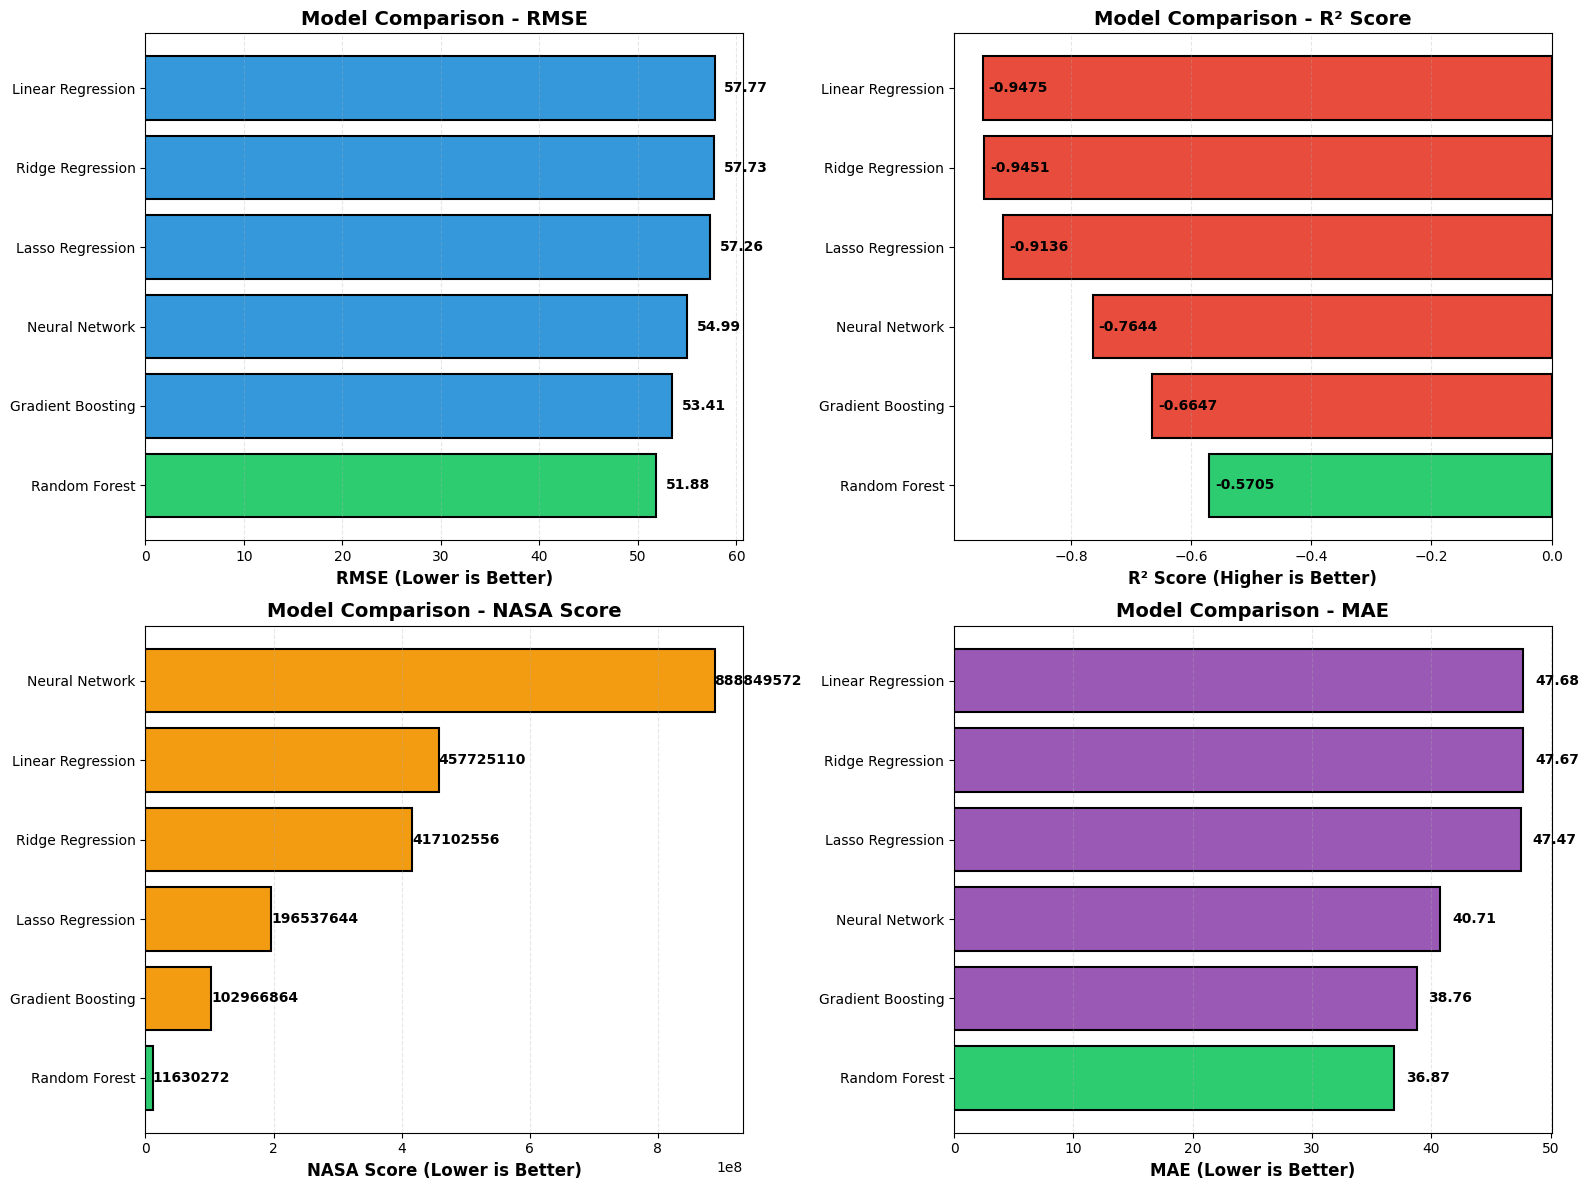

✓ Plot 1: Model Comparison saved


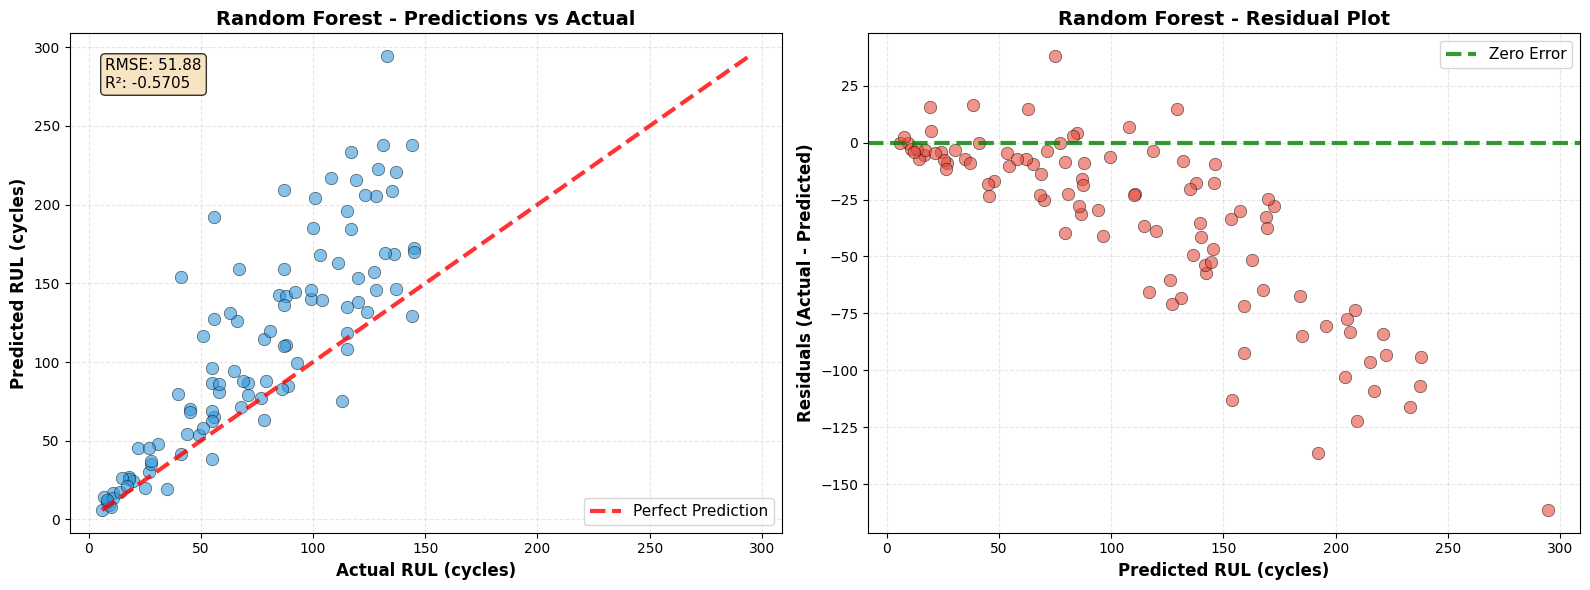

✓ Plot 2: Predictions Analysis saved


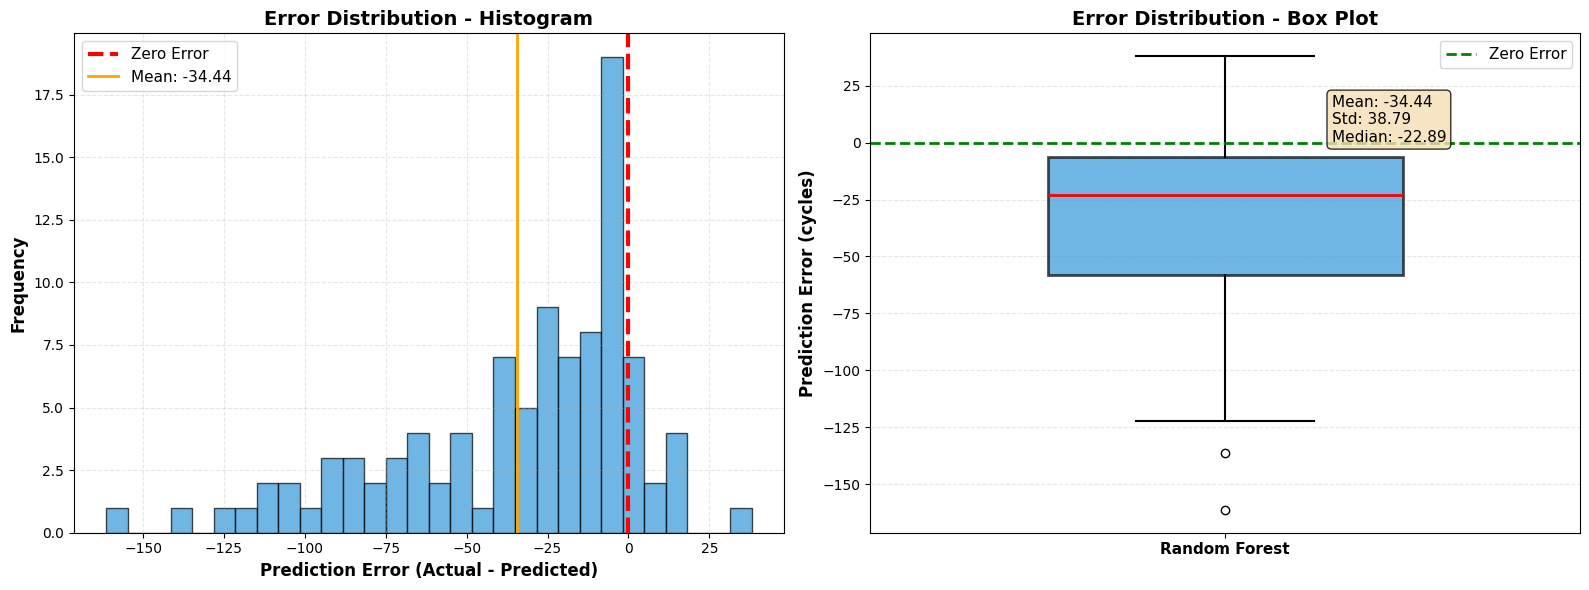

✓ Plot 3: Error Distribution saved


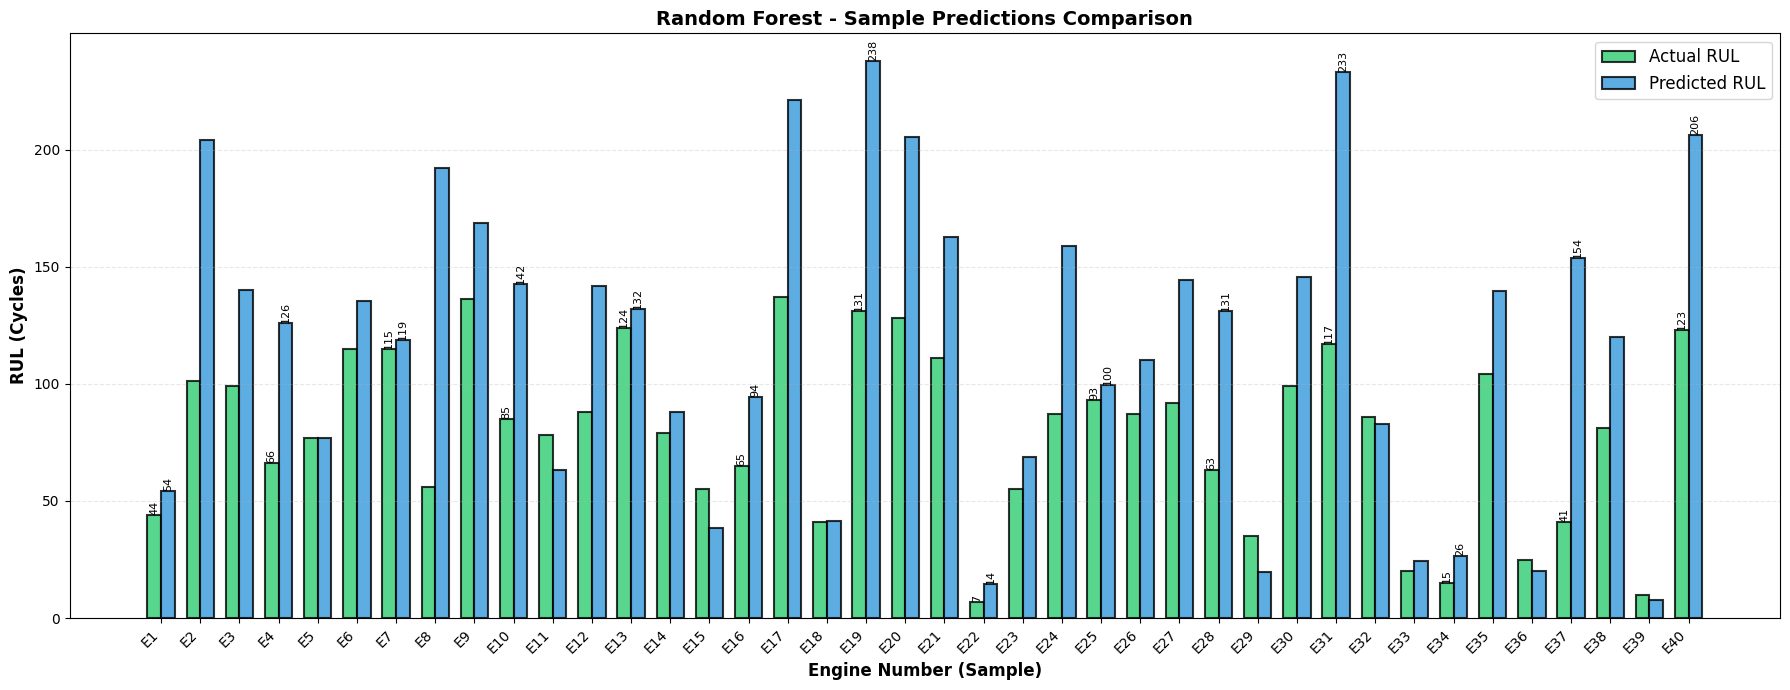

✓ Plot 4: Sample Predictions saved


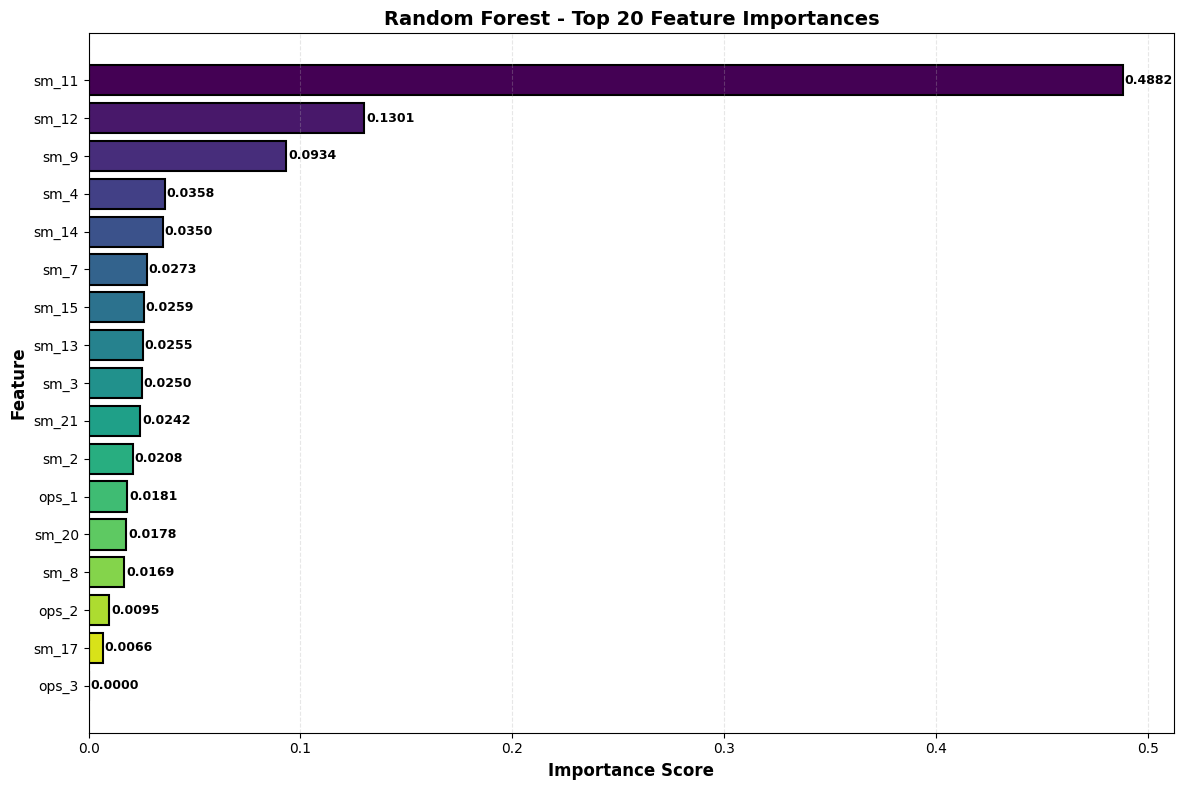

✓ Plot 5: Feature Importance saved


/tmp/ipython-input-140233806.py:427: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-140233806.py:428: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


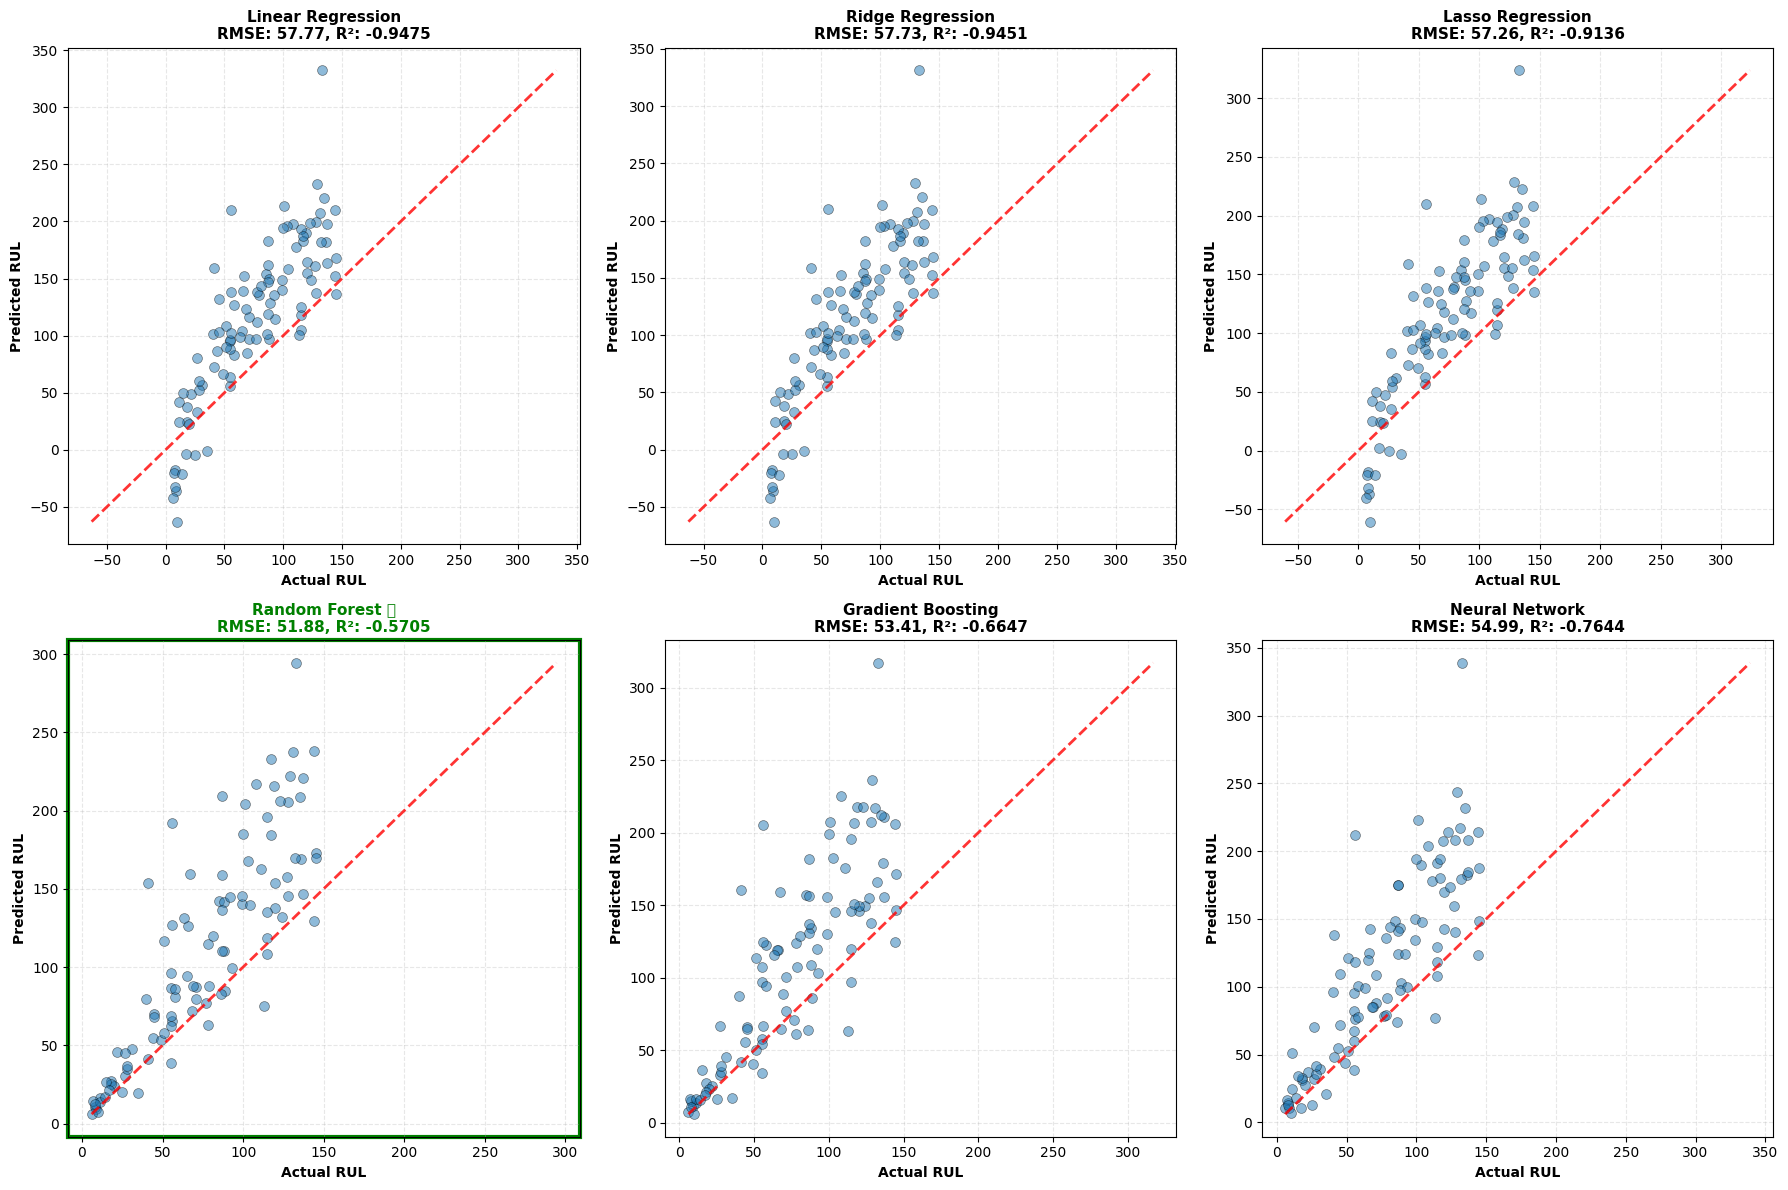

✓ Plot 6: All Models Comparison saved

SAVING RESULTS
✓ Predictions saved to 'rul_predictions.csv'
✓ Model comparison saved to 'model_comparison.csv'
✓ Statistics saved to 'prediction_statistics.csv'

FINAL SUMMARY

📊 Dataset: NASA C-MAPSS FD003
   Training engines: 100
   Test engines: 100
   Features used: 17

🏆 Best Model: Random Forest
   RMSE: 51.88 cycles
   MAE: 36.87 cycles
   R² Score: -0.5705
   NASA Score: 11630271.95

📈 Error Analysis:
   Mean Error: -34.44 cycles
   Std Error: 38.79 cycles
   Median Error: -22.89 cycles
   Within ±10 cycles: 33.0%
   Within ±20 cycles: 46.0%
   Within ±30 cycles: 57.0%


In [7]:
# Prepare final training and test sets
X_train_full = df_train[feature_columns]
y_train_full = df_train['RUL']

# For test: use only the last cycle of each engine
df_test_last = df_test.groupby('unit_number').last().reset_index()
X_test = df_test_last[feature_columns]

# FIX: Get corresponding RUL values for the last cycles only
if 'unit_number' in df_rul.columns:
    # If df_rul has unit numbers, group by unit and take last
    df_rul_last = df_rul.groupby('unit_number').last().reset_index()
    y_test = df_rul_last['RUL'].values
else:
    # NASA C-MAPSS format: df_rul is already one RUL per engine
    y_test = df_rul['RUL'].values

# Verify shapes match
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
assert len(X_test) == len(y_test), f"Shape mismatch! X_test: {len(X_test)}, y_test: {len(y_test)}"

# Split training data for validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# ============================================
# MODEL TRAINING
# ============================================
print("\n" + "="*60)
print("TRAINING MULTIPLE MODELS")
print("="*60)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    """Calculate comprehensive metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # NASA scoring function (asymmetric - penalizes late predictions more)
    errors = y_pred - y_true
    score = 0
    for error in errors:
        if error < 0:  # Early prediction (safer)
            score += np.exp(-error/13) - 1
        else:  # Late prediction (dangerous)
            score += np.exp(error/10) - 1

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'NASA_Score': score
    }

results = []
model_predictions = {}

# Model 1: Linear Regression
print("\n[1/6] Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
model_predictions['Linear Regression'] = y_pred_lr
results.append(evaluate_model(y_test, y_pred_lr, 'Linear Regression'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 2: Ridge Regression
print("\n[2/6] Training Ridge Regression...")
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
model_predictions['Ridge Regression'] = y_pred_ridge
results.append(evaluate_model(y_test, y_pred_ridge, 'Ridge Regression'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 3: Lasso Regression
print("\n[3/6] Training Lasso Regression...")
lasso_model = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
model_predictions['Lasso Regression'] = y_pred_lasso
results.append(evaluate_model(y_test, y_pred_lasso, 'Lasso Regression'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 4: Random Forest
print("\n[4/6] Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
model_predictions['Random Forest'] = y_pred_rf
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 5: Gradient Boosting
print("\n[5/6] Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
model_predictions['Gradient Boosting'] = y_pred_gb
results.append(evaluate_model(y_test, y_pred_gb, 'Gradient Boosting'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# Model 6: Neural Network
print("\n[6/6] Training Neural Network (MLP)...")
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=False
)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
model_predictions['Neural Network'] = y_pred_mlp
results.append(evaluate_model(y_test, y_pred_mlp, 'Neural Network'))
print(f"✓ RMSE: {results[-1]['RMSE']:.2f}, R²: {results[-1]['R²']:.4f}")

# ============================================
# RESULTS COMPARISON
# ============================================
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')
print("\n", results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_predictions = model_predictions[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:.2f} cycles")
print(f"   MAE: {results_df.iloc[0]['MAE']:.2f} cycles")
print(f"   R²: {results_df.iloc[0]['R²']:.4f}")
print(f"   NASA Score: {results_df.iloc[0]['NASA_Score']:.2f}")

# ============================================
# VISUALIZATIONS
# ============================================
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# Calculate residuals
residuals = y_test - best_predictions

# PLOT 1: Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE Comparison
ax = axes[0, 0]
results_sorted = results_df.sort_values('RMSE', ascending=True)
colors = ['#2ecc71' if x == best_model_name else '#3498db' for x in results_sorted['Model']]
ax.barh(results_sorted['Model'], results_sorted['RMSE'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('RMSE (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(results_sorted['RMSE']):
    ax.text(v + 1, i, f'{v:.2f}', va='center', fontweight='bold')

# R² Comparison
ax = axes[0, 1]
results_sorted = results_df.sort_values('R²', ascending=False)
colors = ['#2ecc71' if x == best_model_name else '#e74c3c' for x in results_sorted['Model']]
ax.barh(results_sorted['Model'], results_sorted['R²'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('R² Score (Higher is Better)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(results_sorted['R²']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# NASA Score Comparison
ax = axes[1, 0]
results_sorted = results_df.sort_values('NASA_Score', ascending=True)
colors = ['#2ecc71' if x == best_model_name else '#f39c12' for x in results_sorted['Model']]
ax.barh(results_sorted['Model'], results_sorted['NASA_Score'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('NASA Score (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - NASA Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(results_sorted['NASA_Score']):
    ax.text(v + 50, i, f'{v:.0f}', va='center', fontweight='bold')

# MAE Comparison
ax = axes[1, 1]
results_sorted = results_df.sort_values('MAE', ascending=True)
colors = ['#2ecc71' if x == best_model_name else '#9b59b6' for x in results_sorted['Model']]
ax.barh(results_sorted['Model'], results_sorted['MAE'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('MAE (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - MAE', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(results_sorted['MAE']):
    ax.text(v + 1, i, f'{v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 1: Model Comparison saved")

# PLOT 2: Prediction vs Actual (Best Model)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax = axes[0]
ax.scatter(y_test, best_predictions, alpha=0.6, s=80, color='#3498db', edgecolor='black', linewidth=0.5)
min_val = min(y_test.min(), best_predictions.min())
max_val = max(y_test.max(), best_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Perfect Prediction', alpha=0.8)
ax.set_xlabel('Actual RUL (cycles)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted RUL (cycles)', fontsize=12, fontweight='bold')
ax.set_title(f'{best_model_name} - Predictions vs Actual', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

# Add RMSE annotation
rmse_text = f'RMSE: {results_df.iloc[0]["RMSE"]:.2f}\nR²: {results_df.iloc[0]["R²"]:.4f}'
ax.text(0.05, 0.95, rmse_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Residual plot
ax = axes[1]
ax.scatter(best_predictions, residuals, alpha=0.6, s=80, color='#e74c3c', edgecolor='black', linewidth=0.5)
ax.axhline(y=0, color='green', linestyle='--', lw=3, label='Zero Error', alpha=0.8)
ax.set_xlabel('Predicted RUL (cycles)', fontsize=12, fontweight='bold')
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
ax.set_title(f'{best_model_name} - Residual Plot', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 2: Predictions Analysis saved")

# PLOT 3: Error Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
ax = axes[0]
ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='#3498db')
ax.axvline(x=0, color='red', linestyle='--', lw=3, label='Zero Error')
ax.axvline(x=np.mean(residuals), color='orange', linestyle='-', lw=2, label=f'Mean: {np.mean(residuals):.2f}')
ax.set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Error Distribution - Histogram', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

# Box plot with statistics
ax = axes[1]
bp = ax.boxplot([residuals], vert=True, patch_artist=True, widths=0.5,
                 boxprops=dict(facecolor='#3498db', alpha=0.7, edgecolor='black', linewidth=2),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(color='black', linewidth=1.5),
                 capprops=dict(color='black', linewidth=1.5))
ax.axhline(y=0, color='green', linestyle='--', lw=2, label='Zero Error')
ax.set_ylabel('Prediction Error (cycles)', fontsize=12, fontweight='bold')
ax.set_title('Error Distribution - Box Plot', fontsize=14, fontweight='bold')
ax.set_xticklabels([best_model_name], fontsize=11, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add statistics text
stats_text = f'Mean: {np.mean(residuals):.2f}\nStd: {np.std(residuals):.2f}\nMedian: {np.median(residuals):.2f}'
ax.text(1.15, 0.5, stats_text, transform=ax.transData, fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 3: Error Distribution saved")

# PLOT 4: Sample Predictions Comparison
fig, ax = plt.subplots(figsize=(18, 7))

# Select 40 random samples
np.random.seed(42)
n_samples = min(40, len(y_test))
sample_indices = np.random.choice(len(y_test), n_samples, replace=False)
sample_indices = sorted(sample_indices)

x_pos = np.arange(n_samples)
width = 0.35

# Plot bars
bars1 = ax.bar(x_pos - width/2, y_test[sample_indices], width,
               label='Actual RUL', color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, best_predictions[sample_indices], width,
               label='Predicted RUL', color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    if i % 3 == 0:  # Show labels for every 3rd bar to avoid clutter
        ax.text(bar1.get_x() + bar1.get_width()/2., height1,
                f'{height1:.0f}', ha='center', va='bottom', fontsize=8, rotation=90)
        ax.text(bar2.get_x() + bar2.get_width()/2., height2,
                f'{height2:.0f}', ha='center', va='bottom', fontsize=8, rotation=90)

ax.set_xlabel('Engine Number (Sample)', fontsize=12, fontweight='bold')
ax.set_ylabel('RUL (Cycles)', fontsize=12, fontweight='bold')
ax.set_title(f'{best_model_name} - Sample Predictions Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'E{i+1}' for i in range(n_samples)], rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 4: Sample Predictions saved")

# PLOT 5: Feature Importance (for tree-based models)
if best_model_name == 'Random Forest':
    importance = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df)))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'],
             color=colors, edgecolor='black', linewidth=1.5)
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'{best_model_name} - Top 20 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # Add value labels
    for i, v in enumerate(feature_importance_df['Importance']):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 5: Feature Importance saved")

elif best_model_name == 'Gradient Boosting':
    importance = gb_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.plasma(np.linspace(0, 1, len(feature_importance_df)))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'],
             color=colors, edgecolor='black', linewidth=1.5)
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'{best_model_name} - Top 20 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # Add value labels
    for i, v in enumerate(feature_importance_df['Importance']):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Plot 5: Feature Importance saved")

# PLOT 6: All Models Prediction Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, predictions) in enumerate(model_predictions.items()):
    ax = axes[idx]
    ax.scatter(y_test, predictions, alpha=0.5, s=50, edgecolor='black', linewidth=0.5)

    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)

    # Calculate metrics for this model
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    ax.set_xlabel('Actual RUL', fontsize=10, fontweight='bold')
    ax.set_ylabel('Predicted RUL', fontsize=10, fontweight='bold')

    # Highlight best model
    if model_name == best_model_name:
        ax.set_title(f'{model_name} ⭐\nRMSE: {rmse:.2f}, R²: {r2:.4f}',
                     fontsize=11, fontweight='bold', color='green')
        ax.patch.set_edgecolor('green')
        ax.patch.set_linewidth(3)
    else:
        ax.set_title(f'{model_name}\nRMSE: {rmse:.2f}, R²: {r2:.4f}',
                     fontsize=11, fontweight='bold')

    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 6: All Models Comparison saved")

# ============================================
# SAVE RESULTS
# ============================================
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save predictions
predictions_df = pd.DataFrame({
    'Engine_Number': range(1, len(y_test) + 1),
    'Actual_RUL': y_test,
    'Predicted_RUL': best_predictions,
    'Error': y_test - best_predictions,
    'Absolute_Error': np.abs(y_test - best_predictions),
    'Percentage_Error': np.abs((y_test - best_predictions) / y_test * 100)
})
predictions_df.to_csv('rul_predictions.csv', index=False)
print("✓ Predictions saved to 'rul_predictions.csv'")

# Save model comparison
results_df.to_csv('model_comparison.csv', index=False)
print("✓ Model comparison saved to 'model_comparison.csv'")

# Save detailed statistics
stats_df = pd.DataFrame({
    'Metric': ['Mean Error', 'Std Error', 'Median Error', 'Min Error', 'Max Error',
               'Within ±10 cycles (%)', 'Within ±20 cycles (%)', 'Within ±30 cycles (%)'],
    'Value': [
        np.mean(residuals),
        np.std(residuals),
        np.median(residuals),
        np.min(residuals),
        np.max(residuals),
        (np.abs(residuals) <= 10).sum() / len(residuals) * 100,
        (np.abs(residuals) <= 20).sum() / len(residuals) * 100,
        (np.abs(residuals) <= 30).sum() / len(residuals) * 100
    ]
})
stats_df.to_csv('prediction_statistics.csv', index=False)
print("✓ Statistics saved to 'prediction_statistics.csv'")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\n📊 Dataset: NASA C-MAPSS FD003")
print(f"   Training engines: {df_train['unit_number'].nunique()}")
print(f"   Test engines: {len(y_test)}")
print(f"   Features used: {len(feature_columns)}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:.2f} cycles")
print(f"   MAE: {results_df.iloc[0]['MAE']:.2f} cycles")
print(f"   R² Score: {results_df.iloc[0]['R²']:.4f}")
print(f"   NASA Score: {results_df.iloc[0]['NASA_Score']:.2f}")

print(f"\n📈 Error Analysis:")
print(f"   Mean Error: {np.mean(residuals):.2f} cycles")
print(f"   Std Error: {np.std(residuals):.2f} cycles")
print(f"   Median Error: {np.median(residuals):.2f} cycles")
print(f"   Within ±10 cycles: {(np.abs(residuals) <= 10).sum() / len(residuals) * 100:.1f}%")
print(f"   Within ±20 cycles: {(np.abs(residuals) <= 20).sum() / len(residuals) * 100:.1f}%")
print(f"   Within ±30 cycles: {(np.abs(residuals) <= 30).sum() / len(residuals) * 100:.1f}%")

In [8]:
# ============================================
# HYPERPARAMETER OPTIMIZATION - GRID SEARCH & RANDOM SEARCH
# ============================================

print("\n" + "="*60)
print("HYPERPARAMETER OPTIMIZATION")
print("="*60)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import time

# Store all results including baseline and optimized
all_results = []
all_predictions = {}
optimization_times = []

# Add baseline results to all_results
for result in results:
    all_results.append({**result, 'Type': 'Baseline'})

# Store baseline predictions with type label
for model_name, preds in model_predictions.items():
    all_predictions[f'{model_name} (Baseline)'] = preds

# ============================================
# 1. LINEAR REGRESSION - GRID SEARCH
# ============================================
print("\n[1/8] Linear Regression - Grid Search...")

lr_param_grid = {
    'fit_intercept': [True, False],
    'n_jobs': [None, -1],
    'positive': [True, False]
}

start_time = time.time()

lr_grid = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=lr_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train, y_train)
y_pred_lr_grid = lr_grid.predict(X_test)

end_time = time.time()
optimization_times.append({
    'Model': 'Linear Regression',
    'Method': 'Grid Search',
    'Time': end_time - start_time
})

all_predictions['Linear Regression (Grid Search)'] = y_pred_lr_grid
result = evaluate_model(y_test, y_pred_lr_grid, 'Linear Regression (Grid Search)')
all_results.append({**result, 'Type': 'Grid Search'})

print(f"✓ Best params: {lr_grid.best_params_}")
print(f"✓ Time: {end_time - start_time:.2f}s")
print(f"✓ RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.4f}")

# ============================================
# 2. LINEAR REGRESSION - RANDOM SEARCH
# ============================================
print("\n[2/8] Linear Regression - Random Search...")

lr_param_dist = {
    'fit_intercept': [True, False],
    'n_jobs': [None, -1],
    'positive': [True, False]
}

start_time = time.time()

lr_random = RandomizedSearchCV(
    estimator=LinearRegression(),
    param_distributions=lr_param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

lr_random.fit(X_train, y_train)
y_pred_lr_random = lr_random.predict(X_test)

end_time = time.time()
optimization_times.append({
    'Model': 'Linear Regression',
    'Method': 'Random Search',
    'Time': end_time - start_time
})

all_predictions['Linear Regression (Random Search)'] = y_pred_lr_random
result = evaluate_model(y_test, y_pred_lr_random, 'Linear Regression (Random Search)')
all_results.append({**result, 'Type': 'Random Search'})

print(f"✓ Best params: {lr_random.best_params_}")
print(f"✓ Time: {end_time - start_time:.2f}s")
print(f"✓ RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.4f}")

# ============================================
# 3. RIDGE REGRESSION - GRID SEARCH
# ============================================
print("\n[3/8] Ridge Regression - Grid Search...")

ridge_param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'lsqr', 'sparse_cg']
}

start_time = time.time()

ridge_grid = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=ridge_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

ridge_grid.fit(X_train, y_train)
y_pred_ridge_grid = ridge_grid.predict(X_test)

end_time = time.time()
optimization_times.append({
    'Model': 'Ridge Regression',
    'Method': 'Grid Search',
    'Time': end_time - start_time
})

all_predictions['Ridge Regression (Grid Search)'] = y_pred_ridge_grid
result = evaluate_model(y_test, y_pred_ridge_grid, 'Ridge Regression (Grid Search)')
all_results.append({**result, 'Type': 'Grid Search'})

print(f"✓ Best params: {ridge_grid.best_params_}")
print(f"✓ Time: {end_time - start_time:.2f}s")
print(f"✓ RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.4f}")

# ============================================
# 4. RANDOM FOREST - GRID SEARCH
# ============================================
print("\n[4/8] Random Forest - Grid Search...")

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

start_time = time.time()

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
y_pred_rf_grid = rf_grid.predict(X_test)

end_time = time.time()
optimization_times.append({
    'Model': 'Random Forest',
    'Method': 'Grid Search',
    'Time': end_time - start_time
})

all_predictions['Random Forest (Grid Search)'] = y_pred_rf_grid
result = evaluate_model(y_test, y_pred_rf_grid, 'Random Forest (Grid Search)')
all_results.append({**result, 'Type': 'Grid Search'})

print(f"✓ Best params: {rf_grid.best_params_}")
print(f"✓ Time: {end_time - start_time:.2f}s")
print(f"✓ RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.4f}")

# ============================================
# 5. RANDOM FOREST - RANDOM SEARCH
# ============================================
print("\n[5/8] Random Forest - Random Search...")

rf_param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 10)
}

start_time = time.time()

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=100,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random.fit(X_train, y_train)
y_pred_rf_random = rf_random.predict(X_test)

end_time = time.time()
optimization_times.append({
    'Model': 'Random Forest',
    'Method': 'Random Search',
    'Time': end_time - start_time
})

all_predictions['Random Forest (Random Search)'] = y_pred_rf_random
result = evaluate_model(y_test, y_pred_rf_random, 'Random Forest (Random Search)')
all_results.append({**result, 'Type': 'Random Search'})

print(f"✓ Best params: {rf_random.best_params_}")
print(f"✓ Time: {end_time - start_time:.2f}s")
print(f"✓ RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.4f}")

# ============================================
# 6. SVR - GRID SEARCH
# ============================================
print("\n[6/8] Support Vector Regression - Grid Search...")

svr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.5]
}

start_time = time.time()

svr_grid = GridSearchCV(
    estimator=SVR(),
    param_grid=svr_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

svr_grid.fit(X_train, y_train)
y_pred_svr_grid = svr_grid.predict(X_test)

end_time = time.time()
optimization_times.append({
    'Model': 'SVR',
    'Method': 'Grid Search',
    'Time': end_time - start_time
})

all_predictions['SVR (Grid Search)'] = y_pred_svr_grid
result = evaluate_model(y_test, y_pred_svr_grid, 'SVR (Grid Search)')
all_results.append({**result, 'Type': 'Grid Search'})

print(f"✓ Best params: {svr_grid.best_params_}")
print(f"✓ Time: {end_time - start_time:.2f}s")
print(f"✓ RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.4f}")

# ============================================
# 7. SVR - RANDOM SEARCH
# ============================================
print("\n[7/8] Support Vector Regression - Random Search...")

svr_param_dist = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.5, 1.0]
}

start_time = time.time()

svr_random = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=svr_param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

svr_random.fit(X_train, y_train)
y_pred_svr_random = svr_random.predict(X_test)

end_time = time.time()
optimization_times.append({
    'Model': 'SVR',
    'Method': 'Random Search',
    'Time': end_time - start_time
})

all_predictions['SVR (Random Search)'] = y_pred_svr_random
result = evaluate_model(y_test, y_pred_svr_random, 'SVR (Random Search)')
all_results.append({**result, 'Type': 'Random Search'})

print(f"✓ Best params: {svr_random.best_params_}")
print(f"✓ Time: {end_time - start_time:.2f}s")
print(f"✓ RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.4f}")

# ============================================
# 8. GRADIENT BOOSTING - RANDOM SEARCH
# ============================================
print("\n[8/8] Gradient Boosting - Random Search...")

gb_param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.7, 0.3)
}

start_time = time.time()

gb_random = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=gb_param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

gb_random.fit(X_train, y_train)
y_pred_gb_random = gb_random.predict(X_test)

end_time = time.time()
optimization_times.append({
    'Model': 'Gradient Boosting',
    'Method': 'Random Search',
    'Time': end_time - start_time
})

all_predictions['Gradient Boosting (Random Search)'] = y_pred_gb_random
result = evaluate_model(y_test, y_pred_gb_random, 'Gradient Boosting (Random Search)')
all_results.append({**result, 'Type': 'Random Search'})

print(f"✓ Best params: {gb_random.best_params_}")
print(f"✓ Time: {end_time - start_time:.2f}s")
print(f"✓ RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.4f}")

# ============================================
# COMPLETE RESULTS COMPARISON
# ============================================
print("\n" + "="*60)
print("COMPLETE RESULTS: BASELINE vs OPTIMIZED")
print("="*60)

all_results_df = pd.DataFrame(all_results)
all_results_df = all_results_df.sort_values('RMSE')

print("\n", all_results_df.to_string(index=False))

# Find overall best model
overall_best_name = all_results_df.iloc[0]['Model']
overall_best_predictions = all_predictions[overall_best_name]

print(f"\n🏆 OVERALL BEST MODEL: {overall_best_name}")
print(f"   Type: {all_results_df.iloc[0]['Type']}")
print(f"   RMSE: {all_results_df.iloc[0]['RMSE']:.2f} cycles")
print(f"   MAE: {all_results_df.iloc[0]['MAE']:.2f} cycles")
print(f"   R²: {all_results_df.iloc[0]['R²']:.4f}")
print(f"   NASA Score: {all_results_df.iloc[0]['NASA_Score']:.2f}")

# ============================================
# OPTIMIZATION TIME ANALYSIS
# ============================================
print("\n" + "="*60)
print("OPTIMIZATION TIME ANALYSIS")
print("="*60)

time_df = pd.DataFrame(optimization_times)
print("\n", time_df.to_string(index=False))

# ============================================
# CROSS-VALIDATION ANALYSIS
# ============================================
print("\n" + "="*60)
print("CROSS-VALIDATION ANALYSIS")
print("="*60)

cv_results_list = []

# Linear Regression
print("\n[1/6] Cross-validating Linear Regression...")
start_time = time.time()
cv_scores_lr = cross_val_score(lr_grid.best_estimator_, X_train, y_train,
                                cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_lr = np.sqrt(-cv_scores_lr)
end_time = time.time()

cv_results_list.append({
    'Model': 'Linear Regression (Optimized)',
    'CV Mean RMSE': cv_rmse_lr.mean(),
    'CV Std RMSE': cv_rmse_lr.std(),
    'CV Time': end_time - start_time
})
print(f"✓ CV RMSE: {cv_rmse_lr.mean():.2f} (±{cv_rmse_lr.std():.2f})")

# Ridge Regression
print("\n[2/6] Cross-validating Ridge Regression...")
start_time = time.time()
cv_scores_ridge = cross_val_score(ridge_grid.best_estimator_, X_train, y_train,
                                   cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_ridge = np.sqrt(-cv_scores_ridge)
end_time = time.time()

cv_results_list.append({
    'Model': 'Ridge Regression (Optimized)',
    'CV Mean RMSE': cv_rmse_ridge.mean(),
    'CV Std RMSE': cv_rmse_ridge.std(),
    'CV Time': end_time - start_time
})
print(f"✓ CV RMSE: {cv_rmse_ridge.mean():.2f} (±{cv_rmse_ridge.std():.2f})")

# Random Forest
print("\n[3/6] Cross-validating Random Forest...")
start_time = time.time()
cv_scores_rf = cross_val_score(rf_random.best_estimator_, X_train, y_train,
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_rf = np.sqrt(-cv_scores_rf)
end_time = time.time()

cv_results_list.append({
    'Model': 'Random Forest (Optimized)',
    'CV Mean RMSE': cv_rmse_rf.mean(),
    'CV Std RMSE': cv_rmse_rf.std(),
    'CV Time': end_time - start_time
})
print(f"✓ CV RMSE: {cv_rmse_rf.mean():.2f} (±{cv_rmse_rf.std():.2f})")

# Gradient Boosting
print("\n[4/6] Cross-validating Gradient Boosting...")
start_time = time.time()
cv_scores_gb = cross_val_score(gb_random.best_estimator_, X_train, y_train,
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_gb = np.sqrt(-cv_scores_gb)
end_time = time.time()

cv_results_list.append({
    'Model': 'Gradient Boosting (Optimized)',
    'CV Mean RMSE': cv_rmse_gb.mean(),
    'CV Std RMSE': cv_rmse_gb.std(),
    'CV Time': end_time - start_time
})
print(f"✓ CV RMSE: {cv_rmse_gb.mean():.2f} (±{cv_rmse_gb.std():.2f})")

# SVR (Grid Search)
print("\n[5/6] Cross-validating SVR (Grid Search)...")
start_time = time.time()
cv_scores_svr_grid = cross_val_score(svr_grid.best_estimator_, X_train, y_train,
                                      cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_svr_grid = np.sqrt(-cv_scores_svr_grid)
end_time = time.time()

cv_results_list.append({
    'Model': 'SVR (Grid Search)',
    'CV Mean RMSE': cv_rmse_svr_grid.mean(),
    'CV Std RMSE': cv_rmse_svr_grid.std(),
    'CV Time': end_time - start_time
})
print(f"✓ CV RMSE: {cv_rmse_svr_grid.mean():.2f} (±{cv_rmse_svr_grid.std():.2f})")

# SVR (Random Search)
print("\n[6/6] Cross-validating SVR (Random Search)...")
start_time = time.time()
cv_scores_svr_random = cross_val_score(svr_random.best_estimator_, X_train, y_train,
                                        cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_svr_random = np.sqrt(-cv_scores_svr_random)
end_time = time.time()

cv_results_list.append({
    'Model': 'SVR (Random Search)',
    'CV Mean RMSE': cv_rmse_svr_random.mean(),
    'CV Std RMSE': cv_rmse_svr_random.std(),
    'CV Time': end_time - start_time
})
print(f"✓ CV RMSE: {cv_rmse_svr_random.mean():.2f} (±{cv_rmse_svr_random.std():.2f})")

cv_results_df = pd.DataFrame(cv_results_list)
print("\n", cv_results_df.to_string(index=False))



HYPERPARAMETER OPTIMIZATION

[1/8] Linear Regression - Grid Search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✓ Best params: {'fit_intercept': True, 'n_jobs': None, 'positive': False}
✓ Time: 6.17s
✓ RMSE: 57.77, R²: -0.9475

[2/8] Linear Regression - Random Search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✓ Best params: {'positive': False, 'n_jobs': None, 'fit_intercept': True}
✓ Time: 1.06s
✓ RMSE: 57.77, R²: -0.9475

[3/8] Ridge Regression - Grid Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✓ Best params: {'alpha': 1.0, 'solver': 'lsqr'}
✓ Time: 3.60s
✓ RMSE: 57.73, R²: -0.9452

[4/8] Random Forest - Grid Search...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
✓ Best params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
✓ Time: 3866.48s
✓ RMSE: 49.97, R²: -0.4574

[5/8] Random Forest - Random Search...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
✓ Best params: {'max_depth': 15, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 278}
✓ Time: 5888.52s
✓ RMSE: 49.82, R²: -0.4484

[6/8] Support Vector Regression - Grid Search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
✓ Best params: {'C': 10.0, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
✓ Time: 1

AttributeError: 'numpy.ndarray' object has no attribute 'values'


CREATING ADVANCED VISUALIZATIONS


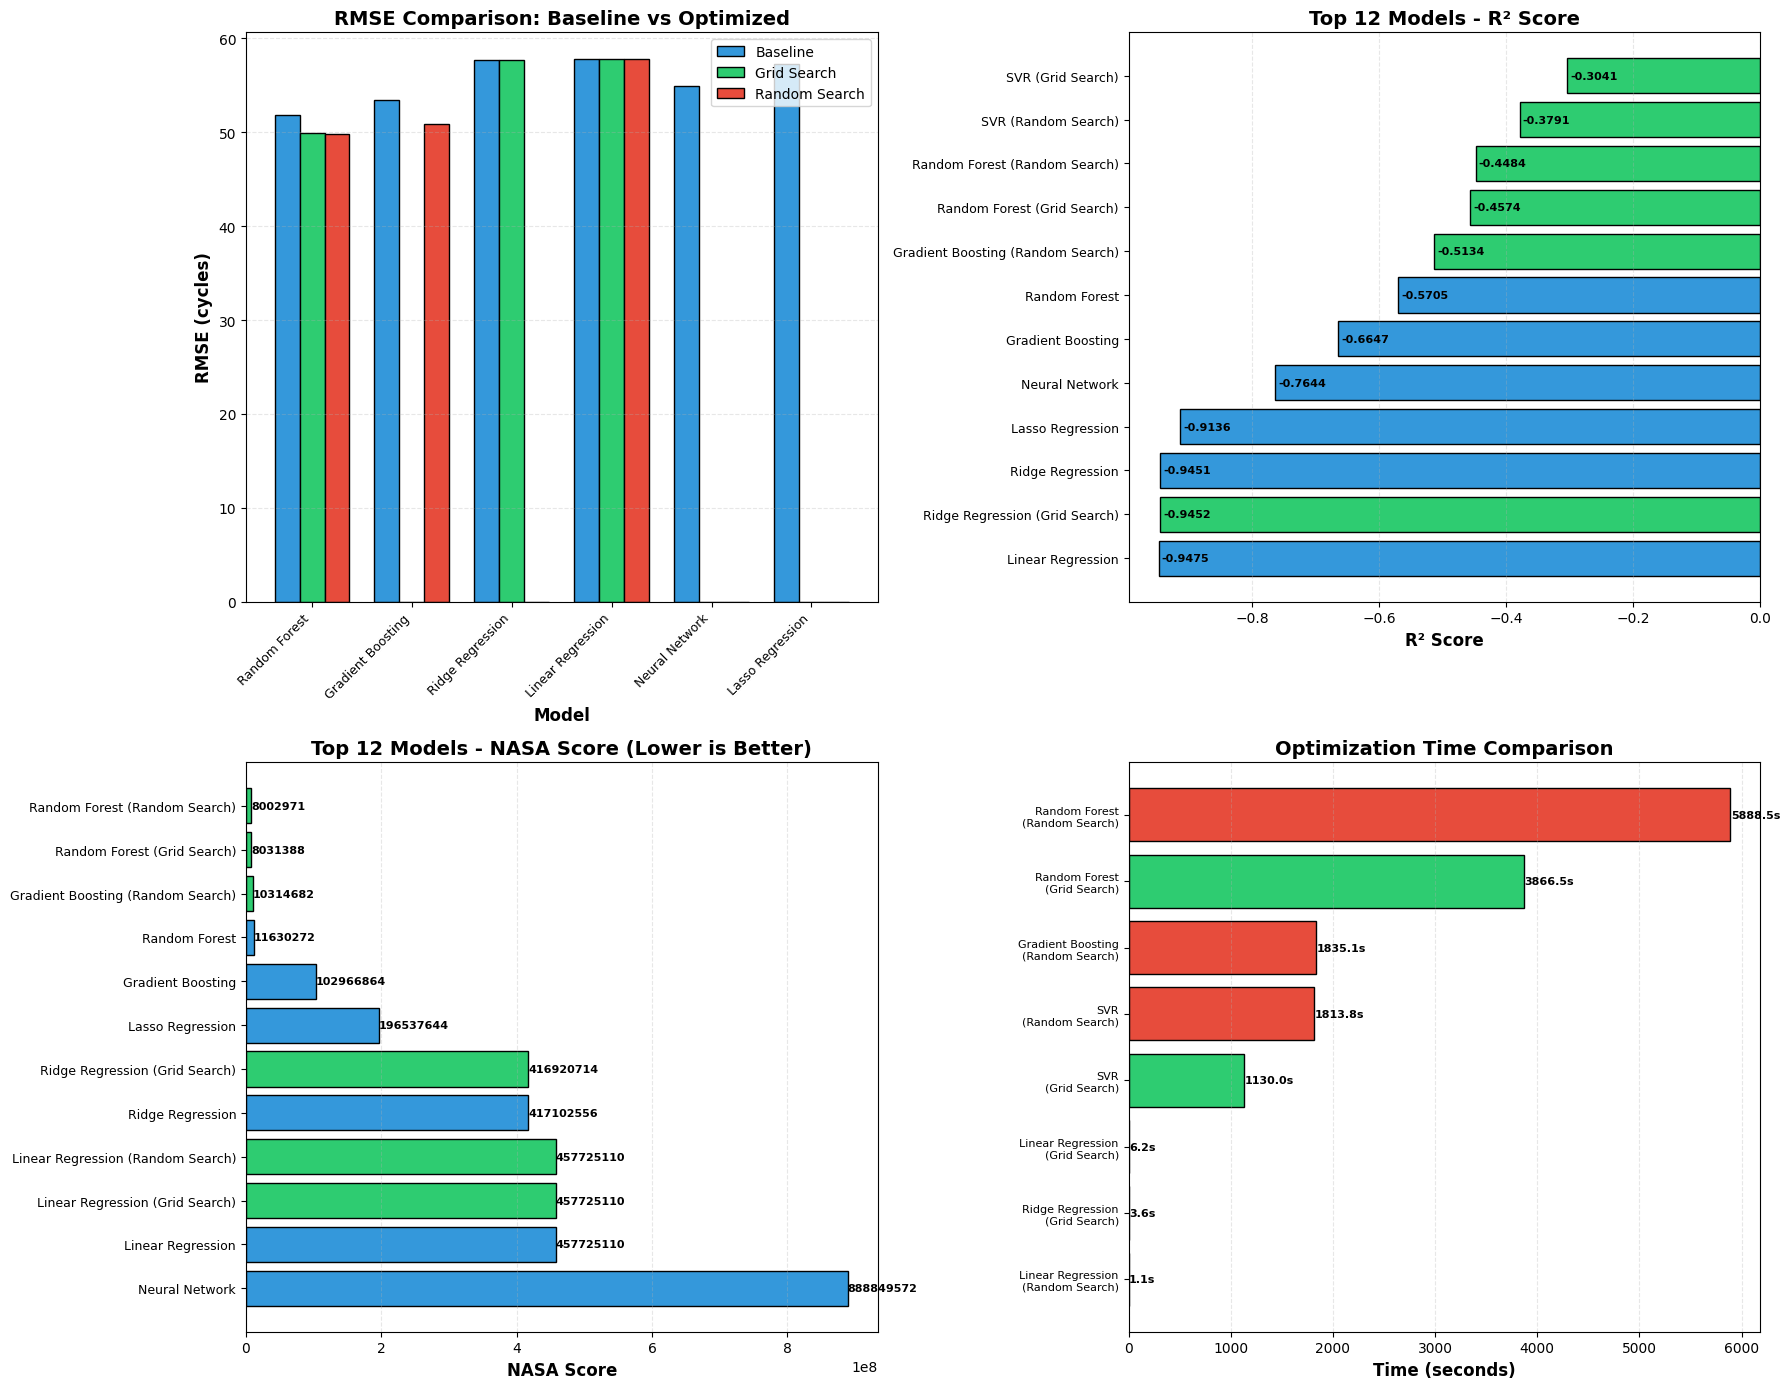

✓ Plot 1: Complete Optimization Comparison saved


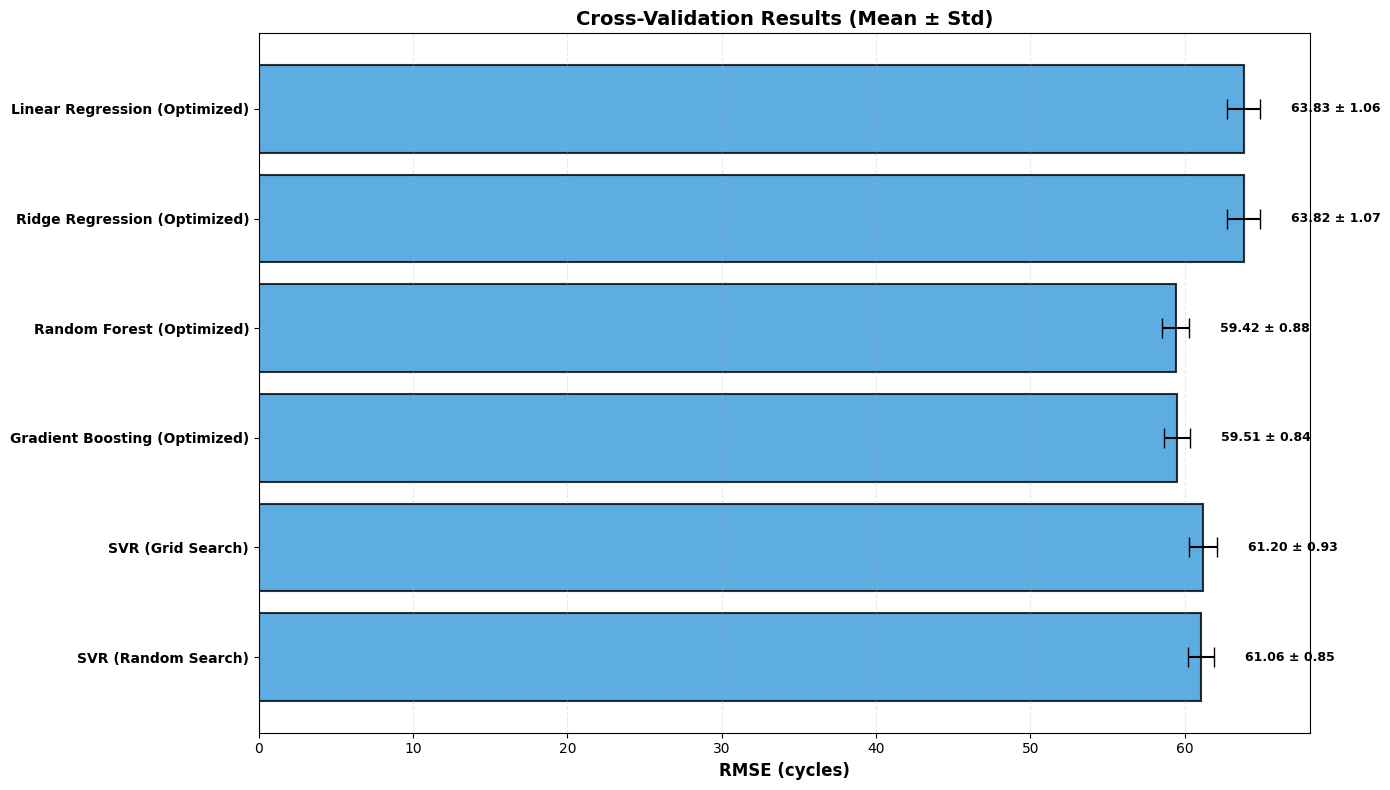

✓ Plot 2: Cross-Validation Results saved


/tmp/ipython-input-4179931761.py:183: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4179931761.py:184: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.savefig('overall_best_model.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


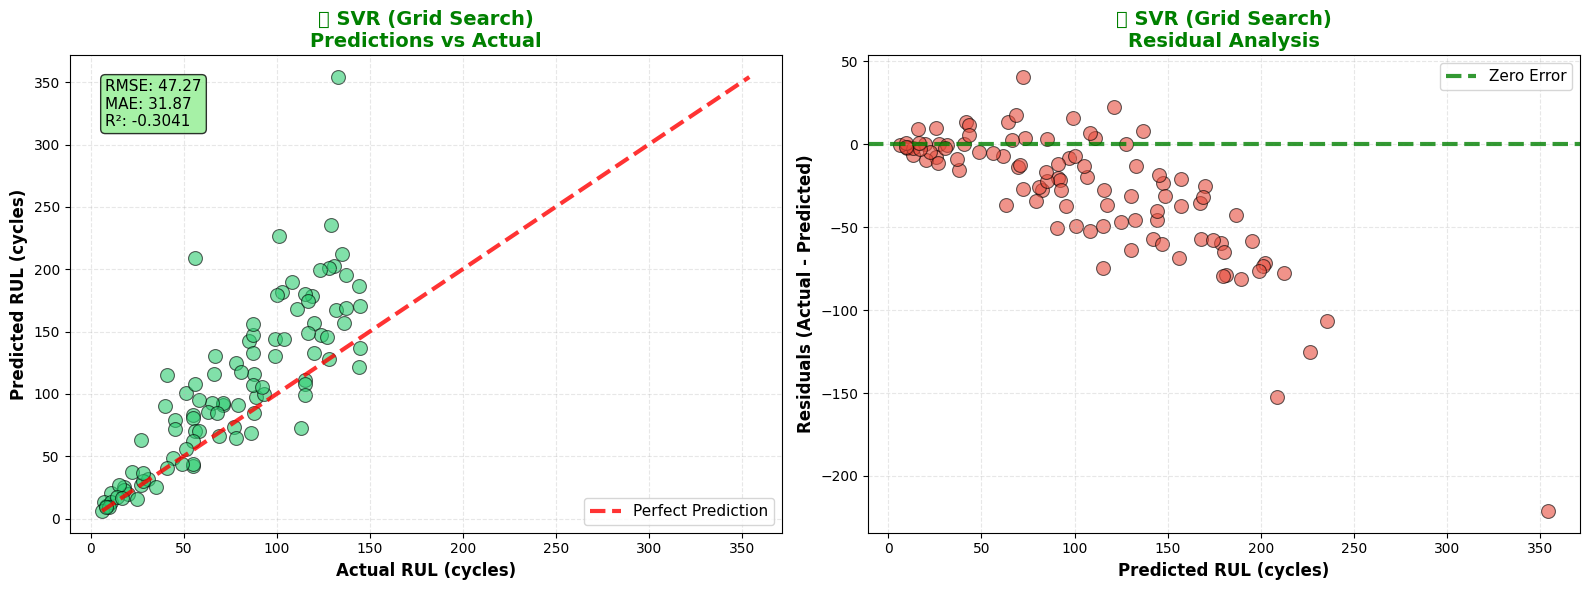

✓ Plot 3: Overall Best Model Performance saved


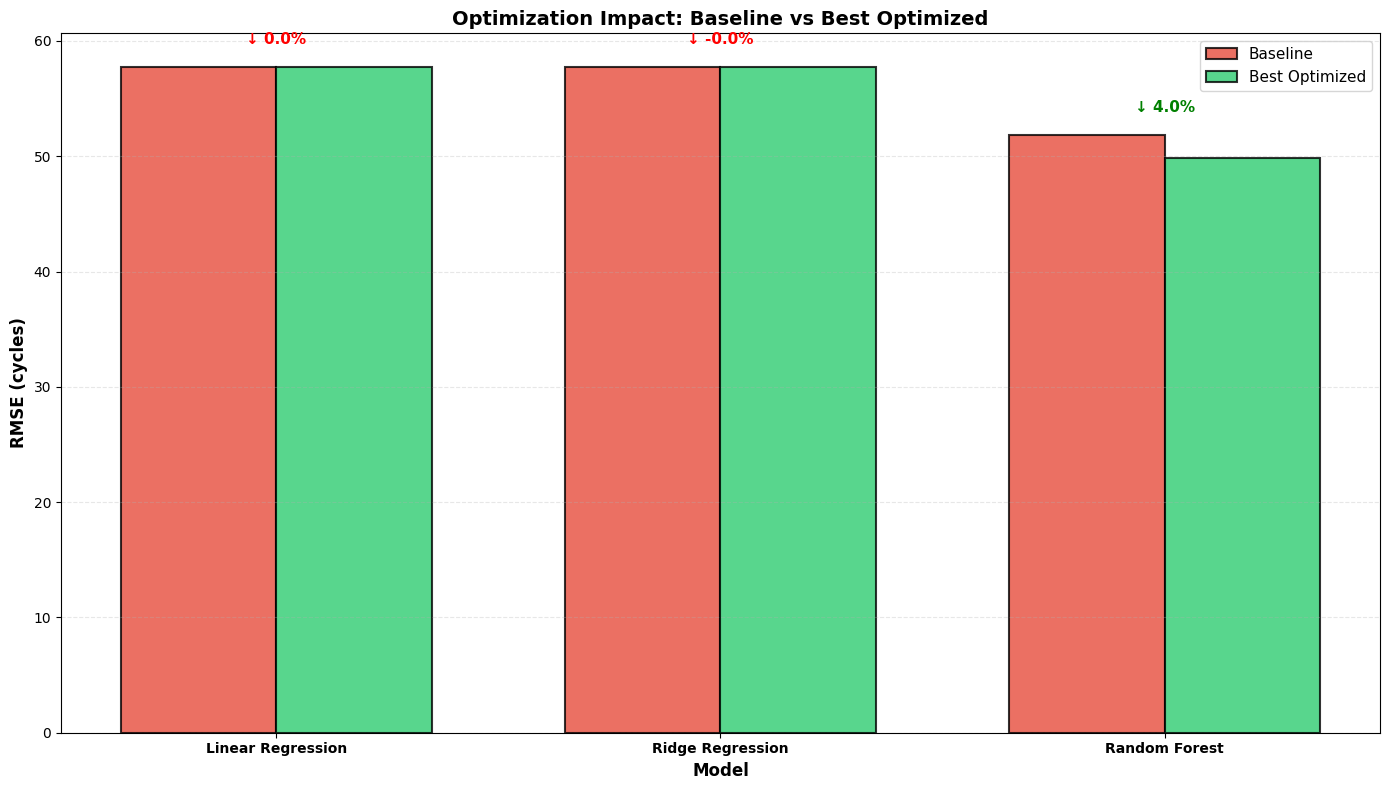

✓ Plot 4: Optimization Improvement saved

SAVING ALL RESULTS
✓ Complete model comparison saved to 'complete_model_comparison.csv'
✓ Optimization times saved to 'optimization_times.csv'
✓ Cross-validation results saved to 'cross_validation_results_optimized.csv'
✓ Best model predictions saved to 'best_model_predictions.csv'
✓ Best hyperparameters saved to 'best_hyperparameters.csv'

FINAL SUMMARY - OPTIMIZED ANALYSIS

📊 Dataset: NASA C-MAPSS FD003
   Training samples: 19776
   Test samples: 100
   Features used: 17

🏆 OVERALL BEST MODEL: SVR (Grid Search)
   Type: Grid Search
   RMSE: 47.27 cycles
   MAE: 31.87 cycles
   R² Score: -0.3041
   NASA Score: 4033191202.09

📈 Performance Insights:
   Mean Error: -28.06 cycles
   Std Error: 38.04 cycles
   Median Error: -20.02 cycles
   Within ±10 cycles: 33.0%
   Within ±20 cycles: 48.0%
   Within ±30 cycles: 60.0%

🔧 Optimization Summary:
   Total models trained: 14
   Baseline models: 6
   Grid Search optimized: 4
   Random Search optimized

In [9]:
# ============================================
# ADVANCED VISUALIZATIONS (FIXED)
# ============================================
print("\n" + "="*60)
print("CREATING ADVANCED VISUALIZATIONS")
print("="*60)

# Calculate residuals for overall best model (FIXED - removed .values)
if isinstance(y_test, np.ndarray):
    overall_best_residuals = y_test - overall_best_predictions
else:
    overall_best_residuals = y_test.values - overall_best_predictions

# PLOT 1: Complete Model Comparison (Baseline + Optimized)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# RMSE by Type
ax = axes[0, 0]
baseline_df = all_results_df[all_results_df['Type'] == 'Baseline']
grid_df = all_results_df[all_results_df['Type'] == 'Grid Search']
random_df = all_results_df[all_results_df['Type'] == 'Random Search']

x = np.arange(len(baseline_df))
width = 0.25

models_base = [m.replace(' (Baseline)', '') for m in baseline_df['Model'].values]
models_unique = list(set(models_base))

# Get RMSE values for each model across types
rmse_data = {'Baseline': [], 'Grid Search': [], 'Random Search': []}
for model in models_unique:
    # Baseline
    base_val = baseline_df[baseline_df['Model'].str.contains(model, case=False, na=False)]['RMSE'].values
    rmse_data['Baseline'].append(base_val[0] if len(base_val) > 0 else 0)

    # Grid Search
    grid_val = grid_df[grid_df['Model'].str.contains(model, case=False, na=False)]['RMSE'].values
    rmse_data['Grid Search'].append(grid_val[0] if len(grid_val) > 0 else 0)

    # Random Search
    random_val = random_df[random_df['Model'].str.contains(model, case=False, na=False)]['RMSE'].values
    rmse_data['Random Search'].append(random_val[0] if len(random_val) > 0 else 0)

x_pos = np.arange(len(models_unique))
bars1 = ax.bar(x_pos - width, rmse_data['Baseline'], width, label='Baseline',
               color='#3498db', edgecolor='black', linewidth=1)
bars2 = ax.bar(x_pos, rmse_data['Grid Search'], width, label='Grid Search',
               color='#2ecc71', edgecolor='black', linewidth=1)
bars3 = ax.bar(x_pos + width, rmse_data['Random Search'], width, label='Random Search',
               color='#e74c3c', edgecolor='black', linewidth=1)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE (cycles)', fontsize=12, fontweight='bold')
ax.set_title('RMSE Comparison: Baseline vs Optimized', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models_unique, rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# R² Score Comparison
ax = axes[0, 1]
all_results_sorted = all_results_df.sort_values('R²', ascending=False).head(12)
colors_r2 = ['#2ecc71' if 'Grid' in t or 'Random' in t else '#3498db'
             for t in all_results_sorted['Type']]
y_pos = np.arange(len(all_results_sorted))
ax.barh(y_pos, all_results_sorted['R²'], color=colors_r2, edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(all_results_sorted['Model'], fontsize=9)
ax.set_xlabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Top 12 Models - R² Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

for i, v in enumerate(all_results_sorted['R²']):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=8, fontweight='bold')

# NASA Score Comparison
ax = axes[1, 0]
all_results_sorted_nasa = all_results_df.sort_values('NASA_Score', ascending=True).head(12)
colors_nasa = ['#2ecc71' if 'Grid' in t or 'Random' in t else '#3498db'
               for t in all_results_sorted_nasa['Type']]
y_pos = np.arange(len(all_results_sorted_nasa))
ax.barh(y_pos, all_results_sorted_nasa['NASA_Score'], color=colors_nasa,
        edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(all_results_sorted_nasa['Model'], fontsize=9)
ax.set_xlabel('NASA Score', fontsize=12, fontweight='bold')
ax.set_title('Top 12 Models - NASA Score (Lower is Better)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

for i, v in enumerate(all_results_sorted_nasa['NASA_Score']):
    ax.text(v + 50, i, f'{v:.0f}', va='center', fontsize=8, fontweight='bold')

# Optimization Time
ax = axes[1, 1]
time_df_sorted = time_df.sort_values('Time', ascending=False)
colors_time = ['#e74c3c' if 'Random' in m else '#2ecc71' for m in time_df_sorted['Method']]
model_labels = [f"{row['Model']}\n({row['Method']})" for _, row in time_df_sorted.iterrows()]
y_pos = np.arange(len(time_df_sorted))
ax.barh(y_pos, time_df_sorted['Time'], color=colors_time, edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(model_labels, fontsize=8)
ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Optimization Time Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

for i, v in enumerate(time_df_sorted['Time']):
    ax.text(v + 5, i, f'{v:.1f}s', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('optimization_complete_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 1: Complete Optimization Comparison saved")

# PLOT 2: Cross-Validation Results
fig, ax = plt.subplots(figsize=(14, 8))

cv_models = cv_results_df['Model'].values
cv_mean = cv_results_df['CV Mean RMSE'].values
cv_std = cv_results_df['CV Std RMSE'].values

x_pos = np.arange(len(cv_models))
bars = ax.barh(x_pos, cv_mean, xerr=cv_std, color='#3498db',
               edgecolor='black', linewidth=1.5, capsize=7, alpha=0.8)

ax.set_yticks(x_pos)
ax.set_yticklabels(cv_models, fontsize=10, fontweight='bold')
ax.set_xlabel('RMSE (cycles)', fontsize=12, fontweight='bold')
ax.set_title('Cross-Validation Results (Mean ± Std)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

for i, (mean_val, std_val) in enumerate(zip(cv_mean, cv_std)):
    ax.text(mean_val + std_val + 2, i, f'{mean_val:.2f} ± {std_val:.2f}',
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('cross_validation_optimized.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 2: Cross-Validation Results saved")

# PLOT 3: Overall Best Model Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot - FIXED: Handle both array and Series
if isinstance(y_test, np.ndarray):
    y_test_array = y_test
else:
    y_test_array = y_test.values

ax = axes[0]
ax.scatter(y_test_array, overall_best_predictions, alpha=0.6, s=100,
           color='#2ecc71', edgecolor='black', linewidth=0.8)
min_val = min(y_test_array.min(), overall_best_predictions.min())
max_val = max(y_test_array.max(), overall_best_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3,
        label='Perfect Prediction', alpha=0.8)
ax.set_xlabel('Actual RUL (cycles)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted RUL (cycles)', fontsize=12, fontweight='bold')
ax.set_title(f'🏆 {overall_best_name}\nPredictions vs Actual',
             fontsize=14, fontweight='bold', color='green')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

metrics_text = f'RMSE: {all_results_df.iloc[0]["RMSE"]:.2f}\nMAE: {all_results_df.iloc[0]["MAE"]:.2f}\nR²: {all_results_df.iloc[0]["R²"]:.4f}'
ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Residual plot
ax = axes[1]
ax.scatter(overall_best_predictions, overall_best_residuals, alpha=0.6, s=100,
           color='#e74c3c', edgecolor='black', linewidth=0.8)
ax.axhline(y=0, color='green', linestyle='--', lw=3, label='Zero Error', alpha=0.8)
ax.set_xlabel('Predicted RUL (cycles)', fontsize=12, fontweight='bold')
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
ax.set_title(f'🏆 {overall_best_name}\nResidual Analysis',
             fontsize=14, fontweight='bold', color='green')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('overall_best_model.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 3: Overall Best Model Performance saved")

# PLOT 4: Improvement from Optimization
fig, ax = plt.subplots(figsize=(14, 8))

improvement_data = []
for model in ['Linear Regression', 'Ridge Regression', 'Random Forest', 'SVR']:
    baseline_rmse = baseline_df[baseline_df['Model'].str.contains(model, case=False)]['RMSE'].values

    optimized_rmses = []
    if model in ['Linear Regression', 'Ridge Regression']:
        grid_rmse = grid_df[grid_df['Model'].str.contains(model, case=False)]['RMSE'].values
        random_rmse = random_df[random_df['Model'].str.contains(model, case=False)]['RMSE'].values
        if len(grid_rmse) > 0:
            optimized_rmses.append(grid_rmse[0])
        if len(random_rmse) > 0:
            optimized_rmses.append(random_rmse[0])
    elif model == 'Random Forest':
        grid_rmse = grid_df[grid_df['Model'].str.contains(model, case=False)]['RMSE'].values
        random_rmse = random_df[random_df['Model'].str.contains(model, case=False)]['RMSE'].values
        if len(grid_rmse) > 0:
            optimized_rmses.append(grid_rmse[0])
        if len(random_rmse) > 0:
            optimized_rmses.append(random_rmse[0])
    elif model == 'SVR':
        grid_rmse = grid_df[grid_df['Model'].str.contains('SVR', case=False)]['RMSE'].values
        random_rmse = random_df[random_df['Model'].str.contains('SVR', case=False)]['RMSE'].values
        if len(grid_rmse) > 0:
            optimized_rmses.append(grid_rmse[0])
        if len(random_rmse) > 0:
            optimized_rmses.append(random_rmse[0])

    if len(baseline_rmse) > 0 and len(optimized_rmses) > 0:
        best_optimized = min(optimized_rmses)
        improvement = ((baseline_rmse[0] - best_optimized) / baseline_rmse[0]) * 100
        improvement_data.append({
            'Model': model,
            'Baseline': baseline_rmse[0],
            'Best Optimized': best_optimized,
            'Improvement %': improvement
        })

if improvement_data:
    improvement_df = pd.DataFrame(improvement_data)

    x_pos = np.arange(len(improvement_df))
    width = 0.35

    bars1 = ax.bar(x_pos - width/2, improvement_df['Baseline'], width,
                   label='Baseline', color='#e74c3c', alpha=0.8,
                   edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x_pos + width/2, improvement_df['Best Optimized'], width,
                   label='Best Optimized', color='#2ecc71', alpha=0.8,
                   edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE (cycles)', fontsize=12, fontweight='bold')
    ax.set_title('Optimization Impact: Baseline vs Best Optimized',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(improvement_df['Model'], fontsize=10, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add improvement percentages
    for i, imp in enumerate(improvement_df['Improvement %']):
        max_height = max(improvement_df['Baseline'].iloc[i],
                        improvement_df['Best Optimized'].iloc[i])
        ax.text(i, max_height + 2, f'↓ {imp:.1f}%',
                ha='center', fontsize=11, fontweight='bold',
                color='green' if imp > 0 else 'red')

plt.tight_layout()
plt.savefig('optimization_improvement.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot 4: Optimization Improvement saved")

# ============================================
# SAVE ALL RESULTS
# ============================================
print("\n" + "="*60)
print("SAVING ALL RESULTS")
print("="*60)

# Save complete model comparison
all_results_df.to_csv('complete_model_comparison.csv', index=False)
print("✓ Complete model comparison saved to 'complete_model_comparison.csv'")

# Save optimization times
time_df.to_csv('optimization_times.csv', index=False)
print("✓ Optimization times saved to 'optimization_times.csv'")

# Save cross-validation results
cv_results_df.to_csv('cross_validation_results_optimized.csv', index=False)
print("✓ Cross-validation results saved to 'cross_validation_results_optimized.csv'")

# Save best model predictions (FIXED)
if isinstance(y_test, np.ndarray):
    y_test_for_save = y_test
else:
    y_test_for_save = y_test.values

best_predictions_df = pd.DataFrame({
    'Engine_Number': range(1, len(y_test) + 1),
    'Actual_RUL': y_test_for_save,
    'Predicted_RUL': overall_best_predictions,
    'Error': y_test_for_save - overall_best_predictions,
    'Absolute_Error': np.abs(y_test_for_save - overall_best_predictions),
    'Percentage_Error': np.abs((y_test_for_save - overall_best_predictions) / y_test_for_save * 100)
})
best_predictions_df.to_csv('best_model_predictions.csv', index=False)
print("✓ Best model predictions saved to 'best_model_predictions.csv'")

# Save best hyperparameters
best_params_data = []
best_params_data.append({'Model': 'Linear Regression (Grid)', 'Parameters': str(lr_grid.best_params_)})
best_params_data.append({'Model': 'Linear Regression (Random)', 'Parameters': str(lr_random.best_params_)})
best_params_data.append({'Model': 'Ridge (Grid)', 'Parameters': str(ridge_grid.best_params_)})
best_params_data.append({'Model': 'Random Forest (Grid)', 'Parameters': str(rf_grid.best_params_)})
best_params_data.append({'Model': 'Random Forest (Random)', 'Parameters': str(rf_random.best_params_)})
best_params_data.append({'Model': 'SVR (Grid)', 'Parameters': str(svr_grid.best_params_)})
best_params_data.append({'Model': 'SVR (Random)', 'Parameters': str(svr_random.best_params_)})
best_params_data.append({'Model': 'Gradient Boosting (Random)', 'Parameters': str(gb_random.best_params_)})

best_params_df = pd.DataFrame(best_params_data)
best_params_df.to_csv('best_hyperparameters.csv', index=False)
print("✓ Best hyperparameters saved to 'best_hyperparameters.csv'")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*60)
print("FINAL SUMMARY - OPTIMIZED ANALYSIS")
print("="*60)

print(f"\n📊 Dataset: NASA C-MAPSS FD003")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(y_test)}")
print(f"   Features used: {len(feature_columns)}")

print(f"\n🏆 OVERALL BEST MODEL: {overall_best_name}")
print(f"   Type: {all_results_df.iloc[0]['Type']}")
print(f"   RMSE: {all_results_df.iloc[0]['RMSE']:.2f} cycles")
print(f"   MAE: {all_results_df.iloc[0]['MAE']:.2f} cycles")
print(f"   R² Score: {all_results_df.iloc[0]['R²']:.4f}")
print(f"   NASA Score: {all_results_df.iloc[0]['NASA_Score']:.2f}")

print(f"\n📈 Performance Insights:")
print(f"   Mean Error: {np.mean(overall_best_residuals):.2f} cycles")
print(f"   Std Error: {np.std(overall_best_residuals):.2f} cycles")
print(f"   Median Error: {np.median(overall_best_residuals):.2f} cycles")
print(f"   Within ±10 cycles: {(np.abs(overall_best_residuals) <= 10).sum() / len(overall_best_residuals) * 100:.1f}%")
print(f"   Within ±20 cycles: {(np.abs(overall_best_residuals) <= 20).sum() / len(overall_best_residuals) * 100:.1f}%")
print(f"   Within ±30 cycles: {(np.abs(overall_best_residuals) <= 30).sum() / len(overall_best_residuals) * 100:.1f}%")

print(f"\n🔧 Optimization Summary:")
print(f"   Total models trained: {len(all_results_df)}")
print(f"   Baseline models: {len(baseline_df)}")
print(f"   Grid Search optimized: {len(grid_df)}")
print(f"   Random Search optimized: {len(random_df)}")
print(f"   Total optimization time: {time_df['Time'].sum():.2f} seconds ({time_df['Time'].sum()/3600:.2f} hours)")